# Neural Network from Scratch
Code modified from https://github.com/adventuresinML/adventures-in-ml-code/blob/master/neural_network_tutorial.py

The notation in this website is almost the same as the notation we are using in class.  Instead of $a$ the author uses $h$, and instead of $N$, the author uses $m$. (I have modified the code below to use $a$ and $N$.)

Please read about this implementation starting at page 27 from the website listed above.

## The first thing we will do is import all the libraries

We will be using the lower resolution MINST data set

In [503]:
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score # 
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 

import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import copy
from itertools import permutations


## Looking at the data

After we load the data, we print the shape of the data and a pixelated digit.

We also show what the features of one example looks like.

The neural net will learn to estimate which digit these pixels represent.

In [504]:
# After completing the code in this code cell, run this code cell before moving further.
names =[
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 
    'restecg',  'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
]

# TODO - write the pandas command to read the csv file into a dataframe df - 5 points
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data',
                 header = None, names = names, na_values = '?')

df = df.dropna()
# print(df.shape)
# print(df.shape)

x=np.array(df.iloc[:,0:13])
y=np.array(df.iloc[:,13:14])

#The goal is to distinguish the presence from non-presense 
for i in range(len(y)):
    if(y[i]>0):
        y[i] = 1

## 1) Scale the dataset
The training features range from 0 to 15.  To help the algorithm converge, we will scale the data to have a mean of 0 and unit variance

In [505]:
X_scale = StandardScaler()
X = X_scale.fit_transform(x)

X[0,:] # Looking the new features after scaling
#print(X.shape[1])

array([ 0.93618065,  0.69109474, -2.24062879,  0.75038004, -0.27644339,
        2.43042728,  1.01019851,  0.01749443, -0.69641941,  1.06896529,
        2.26414539, -0.72197605,  0.65587737])

## 2) Creating training and test datasets
We split the data into training and test data sets. We will train the neural network with the training dataset, and evaluate our neural network with the test dataset 

In [506]:
#Split the data into training and test set.  60% training and %40 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#print(y_test)

## 4) Creating the neural network

### The activation function and its derivative

We will use the sigmoid activation function:  $f(z)=\frac{1}{1+e^{-z}}$

The deriviative of the sigmoid function is: $f'(z) = f(z)(1-f(z))$ 

In [507]:
def f(z):
    return 1 / (1 + np.exp(-z))


def f_deriv(z):
    return f(z) * (1 - f(z))

### Creating and initialing W and b
We want the weights in W to be different so that during back propagation the nodes on a level will have different gradients and thus have different update values.

We want the  weights to be small values, since the sigmoid is almost "flat" for large inputs.

Next is the code that assigns each weight a number uniformly drawn from $[0.0, 1.0)$.  The code assumes that the number of neurons in each level is in the python list *nn_structure*.

In the code, the weights, $W^{(\ell)}$ and $b^{(\ell)}$ are held in a python dictionary

In [508]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

### Initializing $\triangledown W$ and $\triangledown b$
Creating $\triangledown W^{(\ell)}$ and $\triangledown b^{(\ell)}$ to have the same size as $W^{(\ell)}$ and $b^{(\ell)}$, and setting $\triangledown W^{(\ell)}$, and  $\triangledown b^{(\ell)}$ to zero

In [509]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

## Feed forward
Perform a forward pass throught the network.  The function returns the values of $a$ and $z$

In [510]:
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

## Compute $\delta$
The code below compute $\delta^{(s_l)}$ in a function called "calculate_out_layer_delta",  and  computes $\delta^{(\ell)}$ for the hidden layers in the function called "calculate_hidden_delta".  

If we wanted to have a different cost function, we would change the "calculate_out_layer_delta" function.


In [511]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

## The Back Propagation Algorithm


In [512]:
# l=1, input layer

def train_nn(nn_structure, X, y, iter_num, alpha, lamb):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    
    
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        # clean derivative of Ws, since its different every time    
        tri_W, tri_b = init_tri_values(nn_structure)
        
        avg_cost = 0
        
        # for every training sample set
        
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                # last/output layer
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l])) 
                else:
                    #Remember that J/W_l = delta[l+1!!!]*a[l]
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # Since tri W_l = sum(J/w^l) for all xs --> J/w = delta_l+1 * a_l     
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
                    
        # this entire for i in N loop above is updating the  deri. of all W_ls
                    
        # perform the gradient descent step for the weights in EACH LAYER! 
        for l in range(len(nn_structure) - 1, 0, -1):
            # wl and tri_W[l] are both 1D array/vectors
            sum_W = 0
            
            for keys in W:
                for elem in W[keys]:
                    sum_W += np.sum(elem)
            
            
            W[l] += -alpha * (1.0/N * tri_W[l] + 2*lamb*sum_W)
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    #print(avg_cost_func)
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers, threshold):
    N = X.shape[0]
    y = np.zeros((N,))
    
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        if(a[n_layers] > threshold):
            y[i] = 1
        else:
            y[i] = 0         
    return y

## Running the neural network

Our code assumes the size of each layer in our network is held in a list.  The input layer will have 64 neurons (one for each pixel in our 8 by 8 pixelated digit).  Our hidden layer has 30 neurons (you can change this value).  The output layer has 10 neurons.

Next we create the python list to hold the number of neurons for each level and then run the neural network code with our training data.

This code will take some time...

In [513]:
#input layer, 1 hidden layer, 1 output


# train the NN
def main(n_neuro, X_train, y_train, iter_num, alpha, lambs):
    acc_test = []
    acc_train = []
    nn_structure = [13, 1]
    nn_structure.insert(1,n_neuro)
    
    for i in range(len(lambs)):
        W, b, avg_cost_func = train_nn(nn_structure, X_train, y_train, iter_num, alpha, lambs[i])

        plt.plot(avg_cost_func)
        plt.ylabel('Average J')
        plt.xlabel('Iteration number')
        plt.show()
        
        y_hat =  predict_y(W, b, X_train, 3, 0.5)
        y_pred = predict_y(W, b, X_test, 3, 0.5)
        
        print("lambda used:", lambs[i], "n_neurons:", n_neuro)
        print('Training accuracy is {}%'.format(accuracy_score(y_train, y_hat) * 100))
        print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))
        print()
        
        acc_train.append([lambs[i],accuracy_score(y_train, y_hat)])
        acc_test.append([lambs[i],accuracy_score(y_test, y_pred)])
    
    return acc_train, acc_test

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


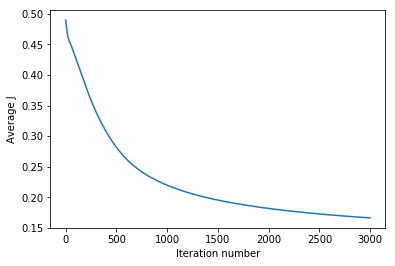

lambda used: 0.0001 n_neurons: 3
Training accuracy is 90.4494382022472%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


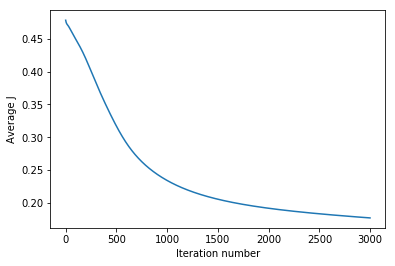

lambda used: 0.00019947365987750282 n_neurons: 3
Training accuracy is 91.01123595505618%
Prediction accuracy is 80.67226890756302%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


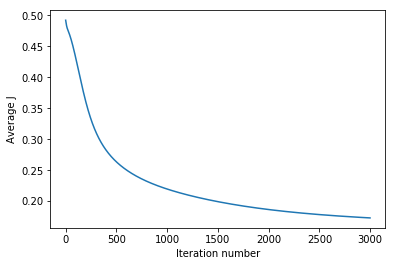

lambda used: 0.00039789740984925683 n_neurons: 3
Training accuracy is 89.8876404494382%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


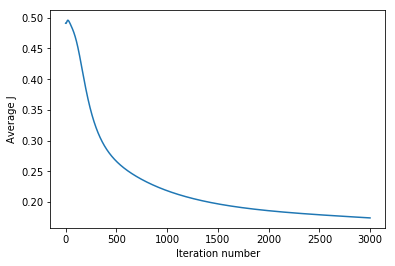

lambda used: 0.0007937005259840992 n_neurons: 3
Training accuracy is 90.4494382022472%
Prediction accuracy is 78.99159663865547%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


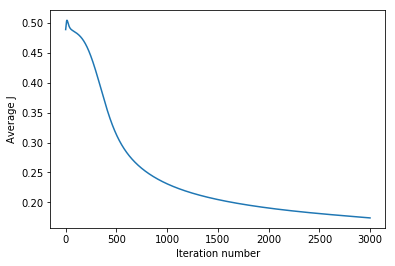

lambda used: 0.0015832234876474746 n_neurons: 3
Training accuracy is 91.57303370786516%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


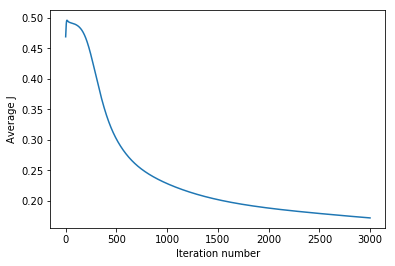

lambda used: 0.003158113834850658 n_neurons: 3
Training accuracy is 91.57303370786516%
Prediction accuracy is 78.15126050420169%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


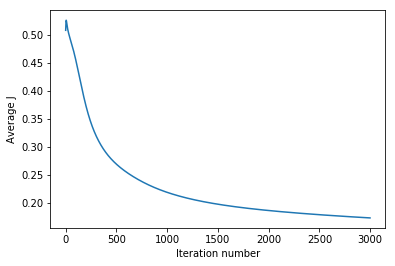

lambda used: 0.006299605249474363 n_neurons: 3
Training accuracy is 91.01123595505618%
Prediction accuracy is 80.67226890756302%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


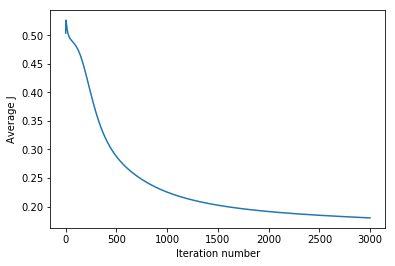

lambda used: 0.012566053148961805 n_neurons: 3
Training accuracy is 89.32584269662921%
Prediction accuracy is 78.99159663865547%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


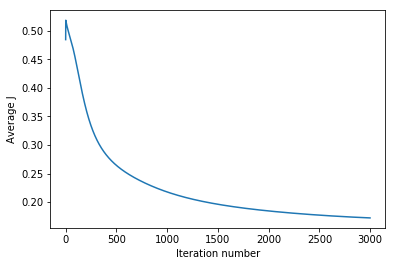

lambda used: 0.025065966118386303 n_neurons: 3
Training accuracy is 89.32584269662921%
Prediction accuracy is 82.35294117647058%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


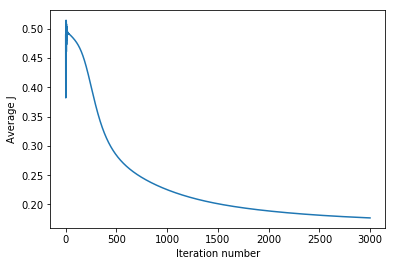

lambda used: 0.049999999999999996 n_neurons: 3
Training accuracy is 91.01123595505618%
Prediction accuracy is 80.67226890756302%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


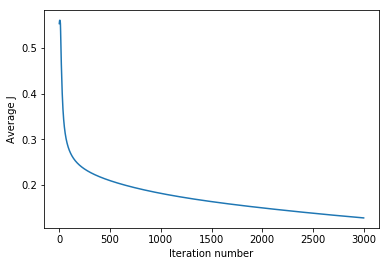

lambda used: 0.0001 n_neurons: 85
Training accuracy is 94.9438202247191%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


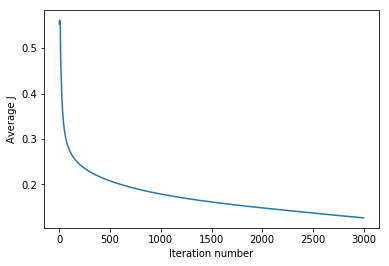

lambda used: 0.00019947365987750282 n_neurons: 85
Training accuracy is 94.9438202247191%
Prediction accuracy is 77.31092436974791%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


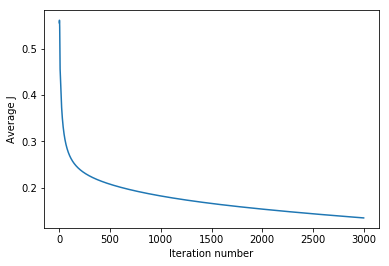

lambda used: 0.00039789740984925683 n_neurons: 85
Training accuracy is 94.9438202247191%
Prediction accuracy is 78.15126050420169%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


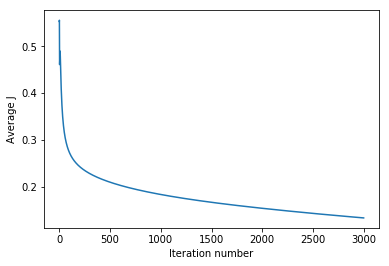

lambda used: 0.0007937005259840992 n_neurons: 85
Training accuracy is 93.25842696629213%
Prediction accuracy is 78.15126050420169%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


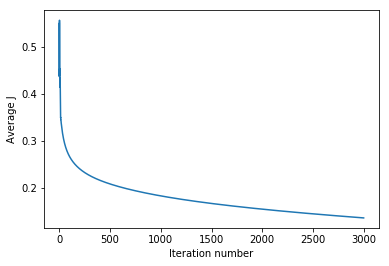

lambda used: 0.0015832234876474746 n_neurons: 85
Training accuracy is 94.3820224719101%
Prediction accuracy is 78.15126050420169%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000


C:\Users\razer\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in double_scalars
C:\Users\razer\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


Iteration 2000 of 3000


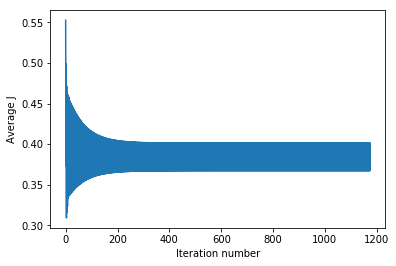

C:\Users\razer\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater


lambda used: 0.003158113834850658 n_neurons: 85
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


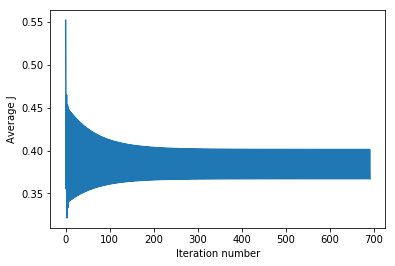

lambda used: 0.006299605249474363 n_neurons: 85
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


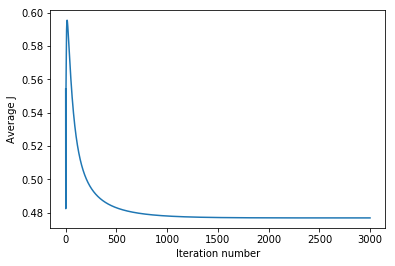

lambda used: 0.012566053148961805 n_neurons: 85
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


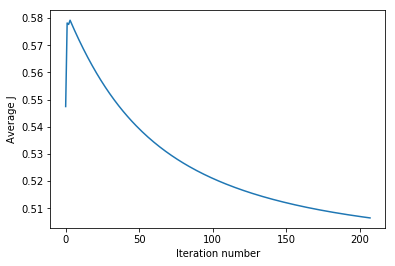

lambda used: 0.025065966118386303 n_neurons: 85
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


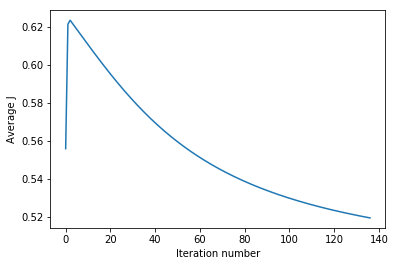

lambda used: 0.049999999999999996 n_neurons: 85
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


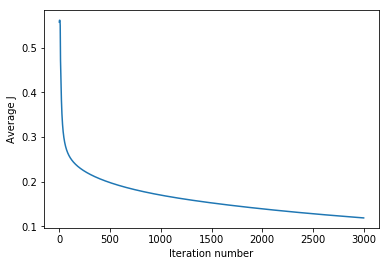

lambda used: 0.0001 n_neurons: 168
Training accuracy is 94.9438202247191%
Prediction accuracy is 77.31092436974791%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


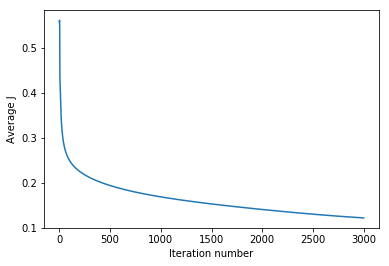

lambda used: 0.00019947365987750282 n_neurons: 168
Training accuracy is 94.9438202247191%
Prediction accuracy is 73.10924369747899%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


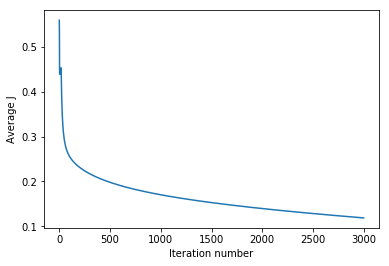

lambda used: 0.00039789740984925683 n_neurons: 168
Training accuracy is 94.9438202247191%
Prediction accuracy is 76.47058823529412%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


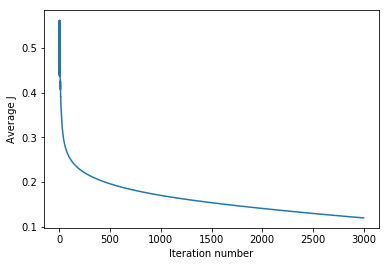

lambda used: 0.0007937005259840992 n_neurons: 168
Training accuracy is 94.9438202247191%
Prediction accuracy is 78.15126050420169%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


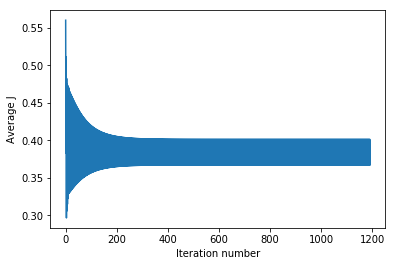

lambda used: 0.0015832234876474746 n_neurons: 168
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


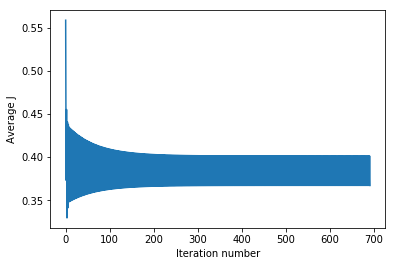

lambda used: 0.003158113834850658 n_neurons: 168
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


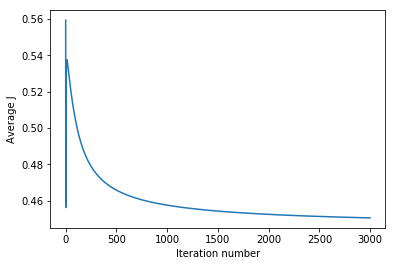

lambda used: 0.006299605249474363 n_neurons: 168
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


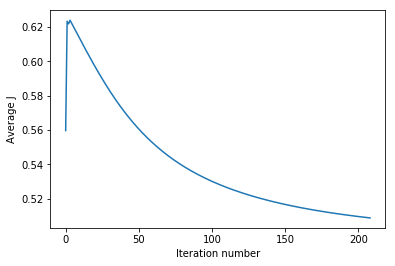

lambda used: 0.012566053148961805 n_neurons: 168
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


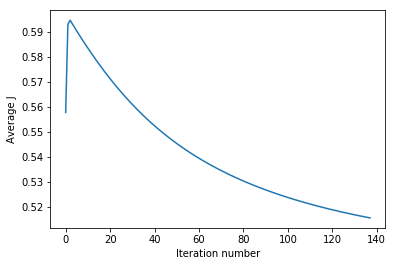

lambda used: 0.025065966118386303 n_neurons: 168
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000


C:\Users\razer\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Iteration 1000 of 3000
Iteration 2000 of 3000


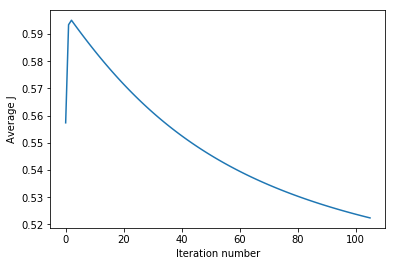

lambda used: 0.049999999999999996 n_neurons: 168
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


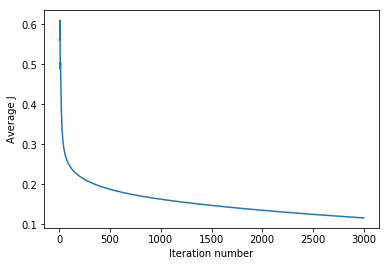

lambda used: 0.0001 n_neurons: 251
Training accuracy is 94.9438202247191%
Prediction accuracy is 75.63025210084034%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


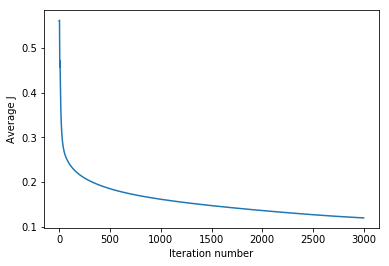

lambda used: 0.00019947365987750282 n_neurons: 251
Training accuracy is 94.9438202247191%
Prediction accuracy is 77.31092436974791%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


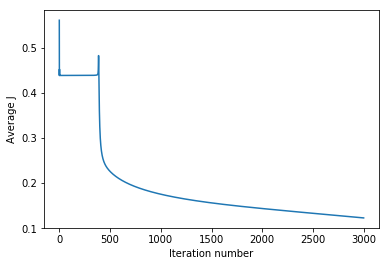

lambda used: 0.00039789740984925683 n_neurons: 251
Training accuracy is 94.9438202247191%
Prediction accuracy is 78.99159663865547%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


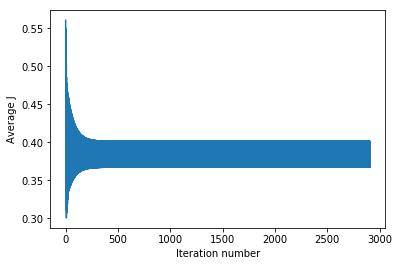

lambda used: 0.0007937005259840992 n_neurons: 251
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


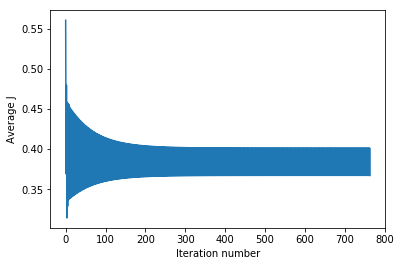

lambda used: 0.0015832234876474746 n_neurons: 251
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


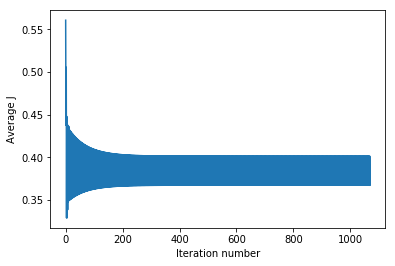

lambda used: 0.003158113834850658 n_neurons: 251
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


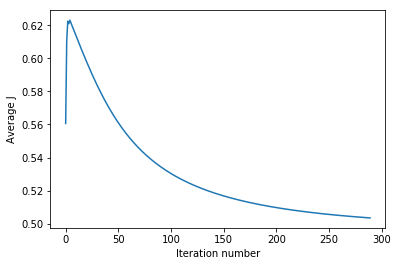

lambda used: 0.006299605249474363 n_neurons: 251
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


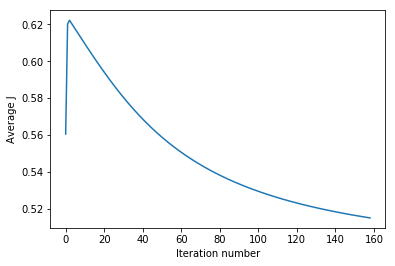

lambda used: 0.012566053148961805 n_neurons: 251
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


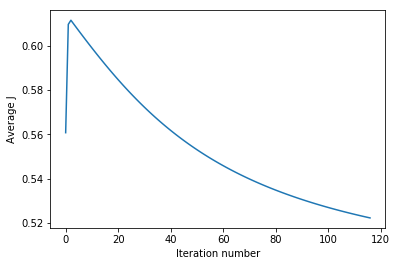

lambda used: 0.025065966118386303 n_neurons: 251
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


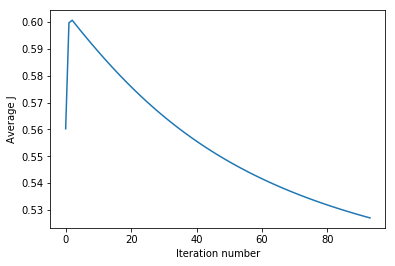

lambda used: 0.049999999999999996 n_neurons: 251
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


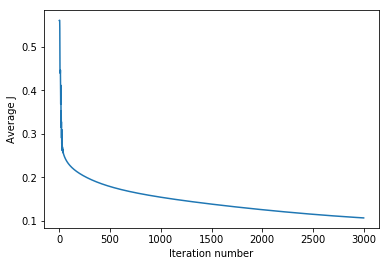

lambda used: 0.0001 n_neurons: 334
Training accuracy is 95.50561797752809%
Prediction accuracy is 78.15126050420169%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


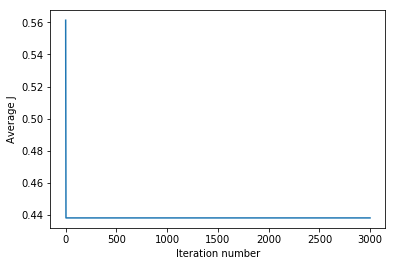

lambda used: 0.00019947365987750282 n_neurons: 334
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


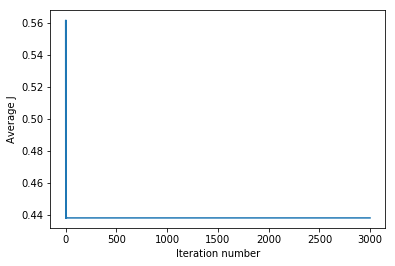

lambda used: 0.00039789740984925683 n_neurons: 334
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


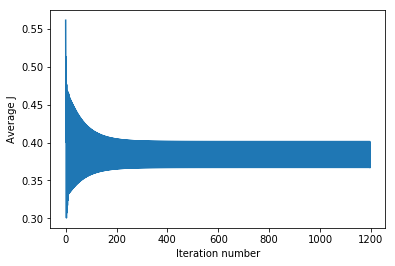

lambda used: 0.0007937005259840992 n_neurons: 334
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


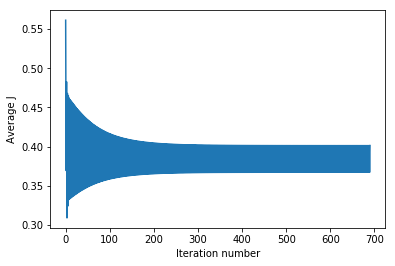

lambda used: 0.0015832234876474746 n_neurons: 334
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


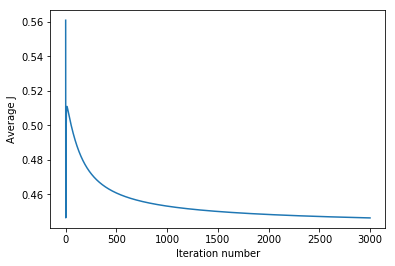

lambda used: 0.003158113834850658 n_neurons: 334
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


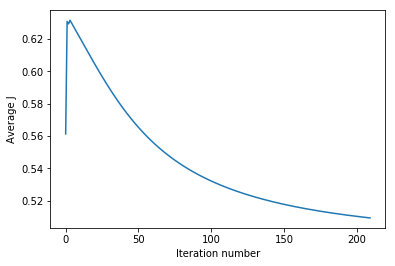

lambda used: 0.006299605249474363 n_neurons: 334
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


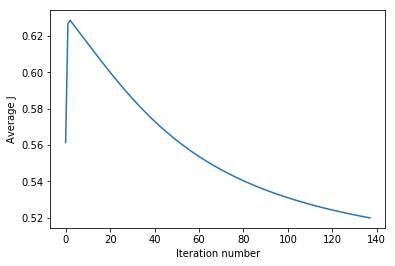

lambda used: 0.012566053148961805 n_neurons: 334
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


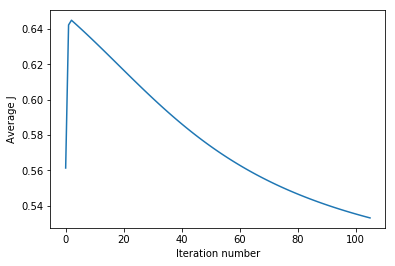

lambda used: 0.025065966118386303 n_neurons: 334
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


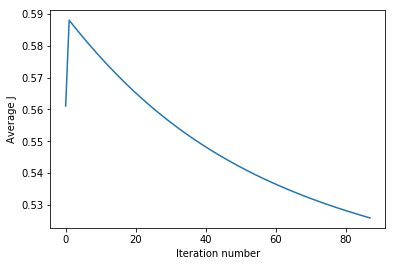

lambda used: 0.049999999999999996 n_neurons: 334
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


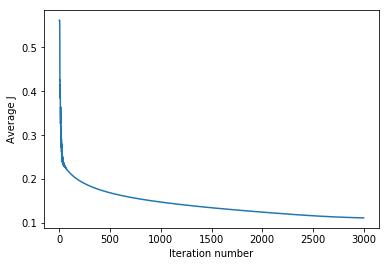

lambda used: 0.0001 n_neurons: 417
Training accuracy is 95.50561797752809%
Prediction accuracy is 76.47058823529412%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


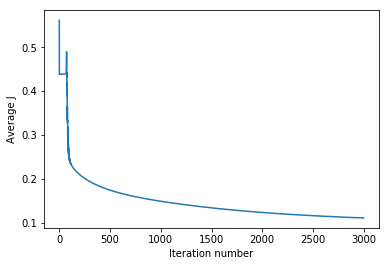

lambda used: 0.00019947365987750282 n_neurons: 417
Training accuracy is 94.9438202247191%
Prediction accuracy is 73.94957983193278%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


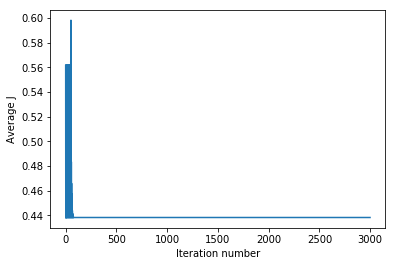

lambda used: 0.00039789740984925683 n_neurons: 417
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


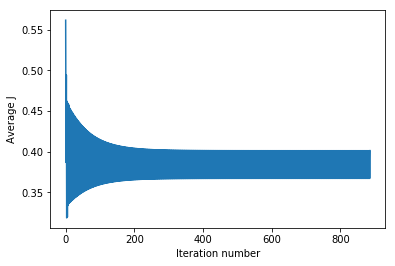

lambda used: 0.0007937005259840992 n_neurons: 417
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


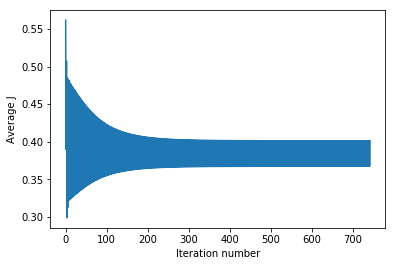

lambda used: 0.0015832234876474746 n_neurons: 417
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


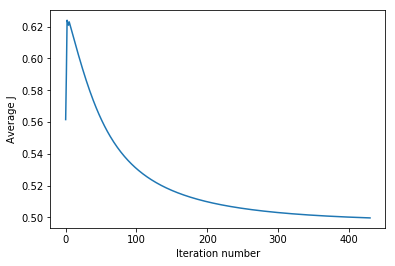

lambda used: 0.003158113834850658 n_neurons: 417
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


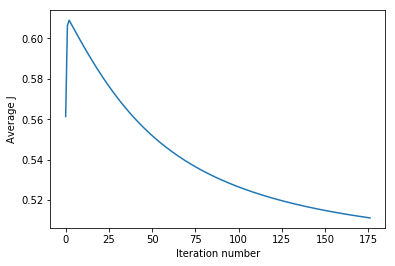

lambda used: 0.006299605249474363 n_neurons: 417
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


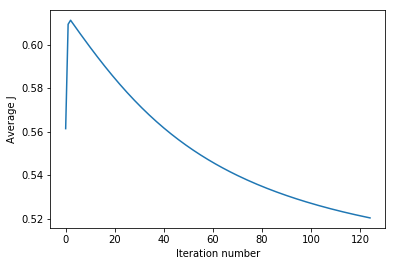

lambda used: 0.012566053148961805 n_neurons: 417
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


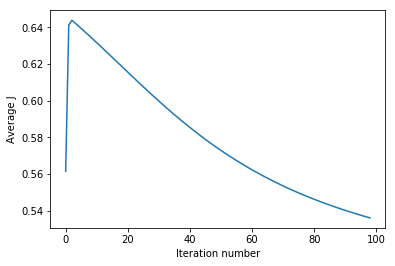

lambda used: 0.025065966118386303 n_neurons: 417
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


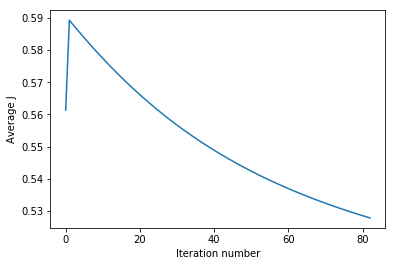

lambda used: 0.049999999999999996 n_neurons: 417
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


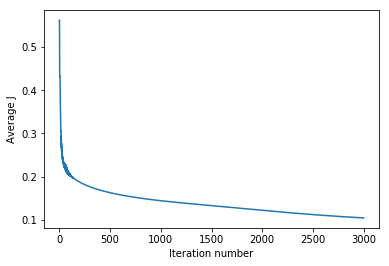

lambda used: 0.0001 n_neurons: 500
Training accuracy is 95.50561797752809%
Prediction accuracy is 77.31092436974791%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


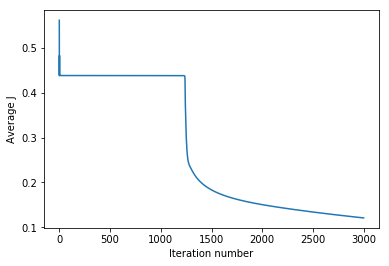

lambda used: 0.00019947365987750282 n_neurons: 500
Training accuracy is 94.9438202247191%
Prediction accuracy is 78.15126050420169%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


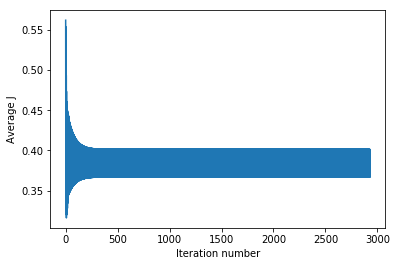

lambda used: 0.00039789740984925683 n_neurons: 500
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


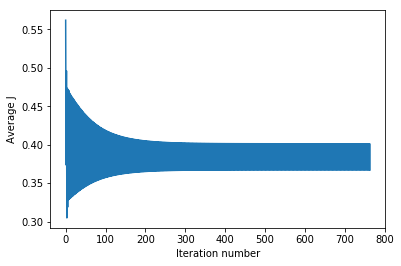

lambda used: 0.0007937005259840992 n_neurons: 500
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


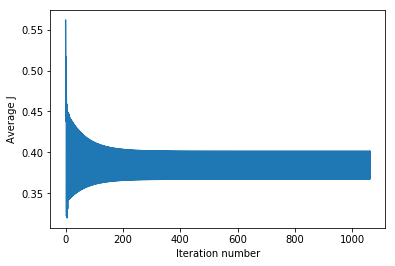

lambda used: 0.0015832234876474746 n_neurons: 500
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


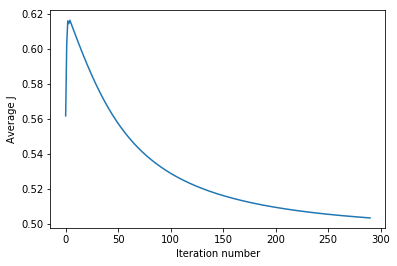

lambda used: 0.003158113834850658 n_neurons: 500
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


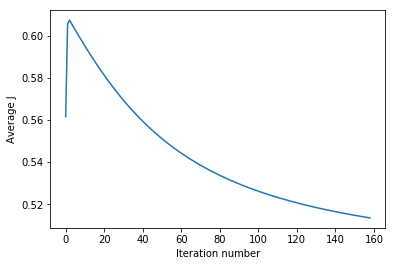

lambda used: 0.006299605249474363 n_neurons: 500
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


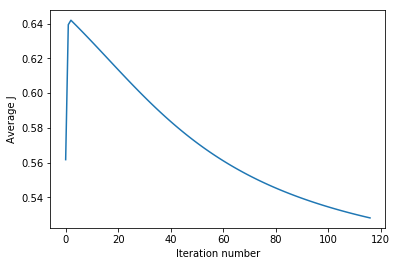

lambda used: 0.012566053148961805 n_neurons: 500
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


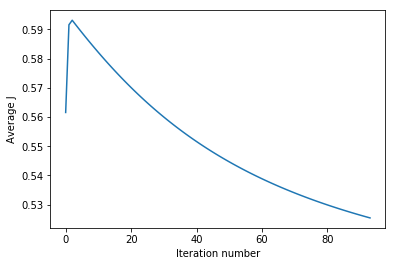

lambda used: 0.025065966118386303 n_neurons: 500
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


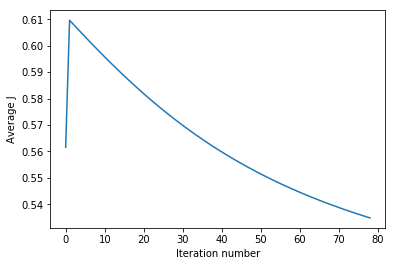

lambda used: 0.049999999999999996 n_neurons: 500
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%



In [514]:
info = [int(elem) for elem in np.linspace(3,500,7)]
lambs = np.geomspace(0.0001, 0.05, 10)

# print(info)
# print(lambs)
res = {}

for n_neuro in info:
    res[n_neuro] = []

    
for n_neuro in info: 
    acc_tr, acc_test = main(n_neuro, X_train, y_train, 3000, 0.5, lambs)

    res[n_neuro].append(acc_tr)
    res[n_neuro].append(acc_test)


Tr_acc, 3
0.9044943820224719
0.9101123595505618
0.898876404494382
0.9044943820224719
0.9157303370786517
0.9157303370786517
0.9101123595505618
0.8932584269662921
0.8932584269662921
0.9101123595505618

Test_acc, 3
0.7983193277310925
0.8067226890756303
0.7983193277310925
0.7899159663865546
0.7983193277310925
0.7815126050420168
0.8067226890756303
0.7899159663865546
0.8235294117647058
0.8067226890756303



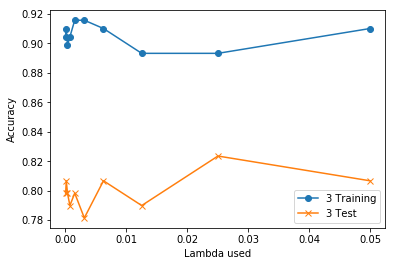


Tr_acc, 85
0.949438202247191
0.949438202247191
0.949438202247191
0.9325842696629213
0.9438202247191011
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888

Test_acc, 85
0.7983193277310925
0.773109243697479
0.7815126050420168
0.7815126050420168
0.7815126050420168
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689



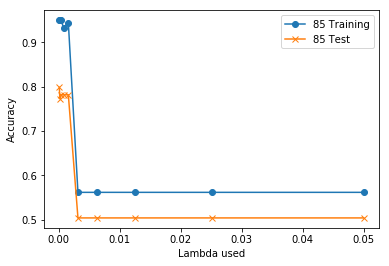


Tr_acc, 168
0.949438202247191
0.949438202247191
0.949438202247191
0.949438202247191
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888

Test_acc, 168
0.773109243697479
0.7310924369747899
0.7647058823529411
0.7815126050420168
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689



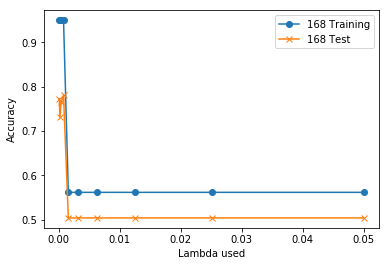


Tr_acc, 251
0.949438202247191
0.949438202247191
0.949438202247191
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888

Test_acc, 251
0.7563025210084033
0.773109243697479
0.7899159663865546
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689



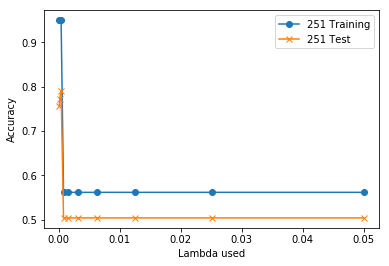


Tr_acc, 334
0.9550561797752809
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888

Test_acc, 334
0.7815126050420168
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689



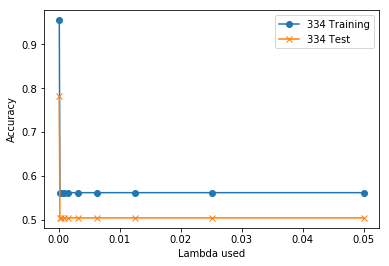


Tr_acc, 417
0.9550561797752809
0.949438202247191
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888

Test_acc, 417
0.7647058823529411
0.7394957983193278
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689



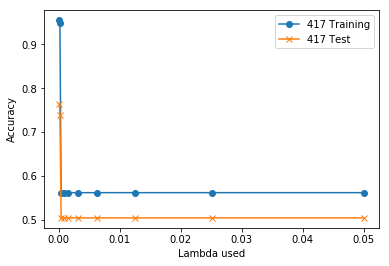


Tr_acc, 500
0.9550561797752809
0.949438202247191
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888
0.5617977528089888

Test_acc, 500
0.773109243697479
0.7815126050420168
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689
0.5042016806722689



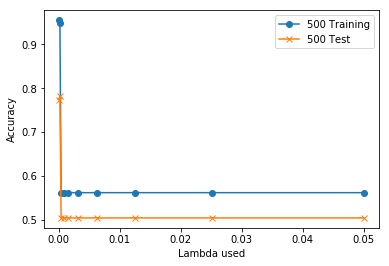

In [515]:
# for elem in res:
#     print(elem)
#     print()
# print(len(res))
x = lambs

for n_neu in res:
    tr_lst = []
    test_lst = []
    
    print()
    print("Tr_acc,",n_neu)
    for tr_accs in res[n_neu][0]:
        tr_lst.append(tr_accs[1])
        print(tr_accs[1])
        
    print()
    
    print("Test_acc,",n_neu)
    for test_accs in res[n_neu][1]:
        test_lst.append(test_accs[1])
        print(test_accs[1])
    print()
    
    plt.plot(x,tr_lst,marker='o', label=str(n_neu)+" Training")
    plt.plot(x,test_lst,marker='x', label=str(n_neu)+" Test")
    
    plt.xlabel('Lambda used')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# for elem in res[1][1]:
#     print(elem[1])
# for lamb in lambs:
#     print(lamb)
# x = lambs
# y_4, y_300, y_1000 = [nums[1] for nums in res[0][1]], [nums[1] for nums in res[1][1]], [nums[1] for nums in res[2][1]]
# plt.plot(x,y_4,marker='o')
# plt.plot(x,y_300,marker='o')
# plt.plot(x,y_1000,marker='o')
# # plt.xticks(np.arange(min(x), max(x)+1, 5))
# plt.xlabel('Lambda used')
# plt.ylabel('Accuracy')
# plt.show()

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


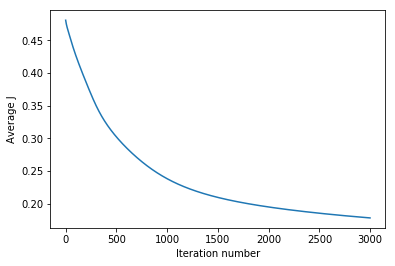

lambda used: 4.9999999999999996e-05 n_neurons: 3
Training accuracy is 91.57303370786516%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


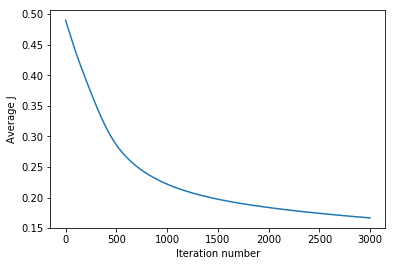

lambda used: 9.729438587881949e-05 n_neurons: 3
Training accuracy is 92.13483146067416%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


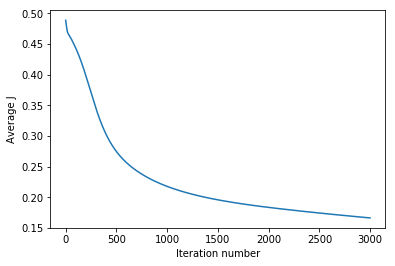

lambda used: 0.00018932395047073242 n_neurons: 3
Training accuracy is 92.13483146067416%
Prediction accuracy is 77.31092436974791%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


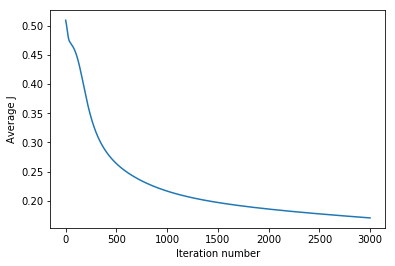

lambda used: 0.00036840314986403866 n_neurons: 3
Training accuracy is 91.01123595505618%
Prediction accuracy is 78.15126050420169%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


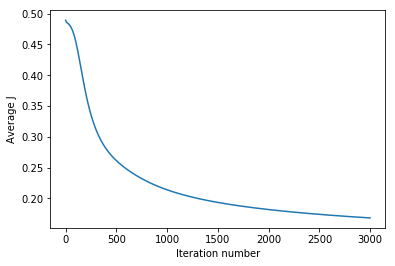

lambda used: 0.000716871164436887 n_neurons: 3
Training accuracy is 90.4494382022472%
Prediction accuracy is 81.5126050420168%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


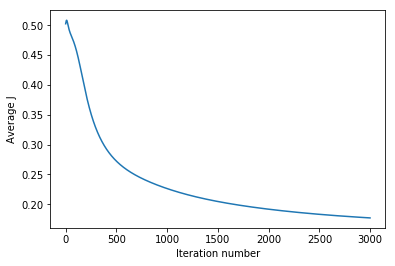

lambda used: 0.0013949507939624215 n_neurons: 3
Training accuracy is 89.32584269662921%
Prediction accuracy is 82.35294117647058%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


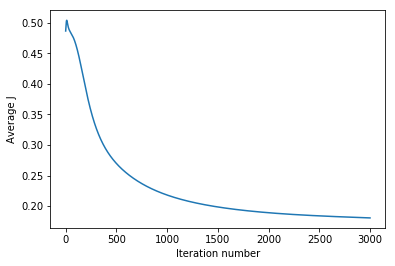

lambda used: 0.002714417616594907 n_neurons: 3
Training accuracy is 89.32584269662921%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


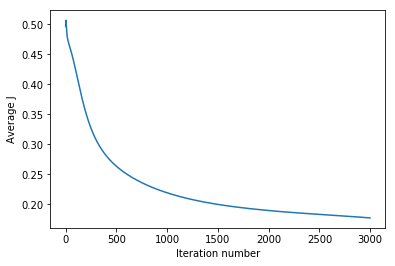

lambda used: 0.005281951900505007 n_neurons: 3
Training accuracy is 91.01123595505618%
Prediction accuracy is 78.15126050420169%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


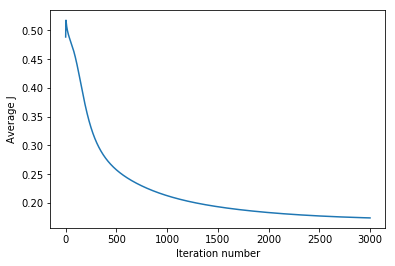

lambda used: 0.010278085328021954 n_neurons: 3
Training accuracy is 89.8876404494382%
Prediction accuracy is 82.35294117647058%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


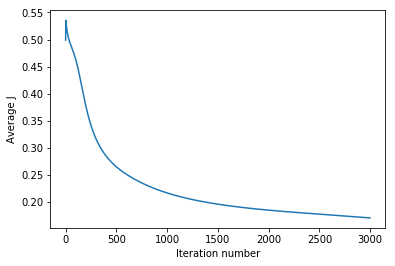

lambda used: 0.020000000000000004 n_neurons: 3
Training accuracy is 90.4494382022472%
Prediction accuracy is 78.99159663865547%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


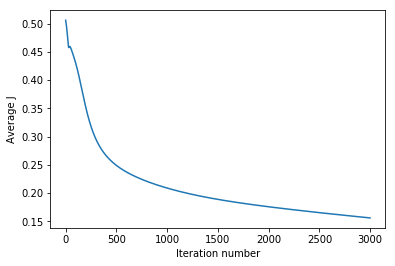

lambda used: 4.9999999999999996e-05 n_neurons: 10
Training accuracy is 91.57303370786516%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


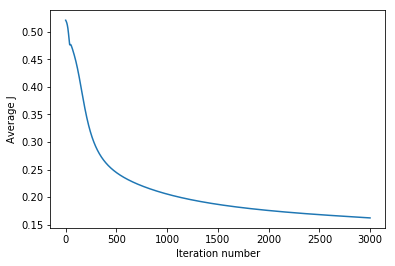

lambda used: 9.729438587881949e-05 n_neurons: 10
Training accuracy is 89.8876404494382%
Prediction accuracy is 81.5126050420168%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


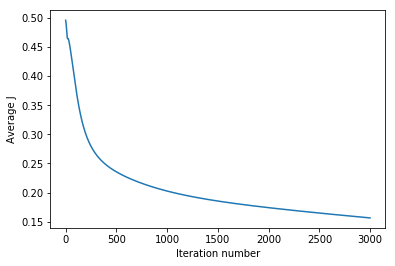

lambda used: 0.00018932395047073242 n_neurons: 10
Training accuracy is 93.82022471910112%
Prediction accuracy is 77.31092436974791%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


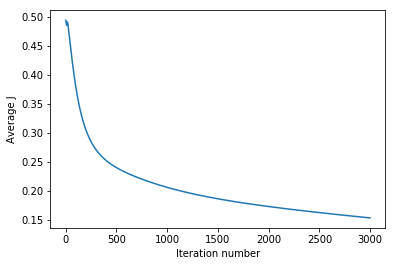

lambda used: 0.00036840314986403866 n_neurons: 10
Training accuracy is 93.25842696629213%
Prediction accuracy is 82.35294117647058%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


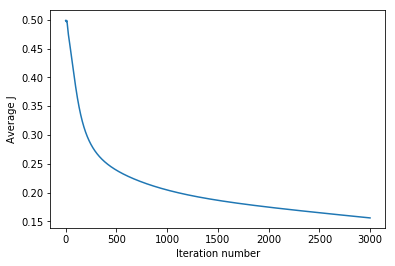

lambda used: 0.000716871164436887 n_neurons: 10
Training accuracy is 93.25842696629213%
Prediction accuracy is 81.5126050420168%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


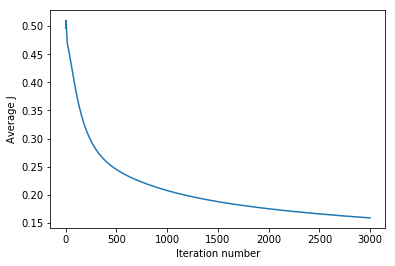

lambda used: 0.0013949507939624215 n_neurons: 10
Training accuracy is 91.01123595505618%
Prediction accuracy is 81.5126050420168%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


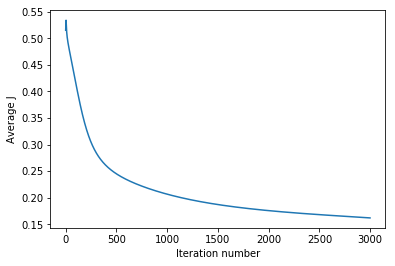

lambda used: 0.002714417616594907 n_neurons: 10
Training accuracy is 89.8876404494382%
Prediction accuracy is 80.67226890756302%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


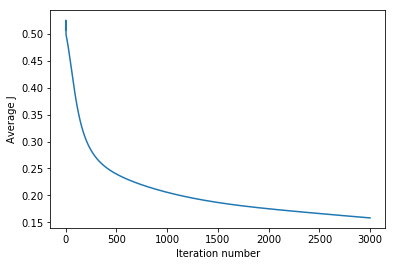

lambda used: 0.005281951900505007 n_neurons: 10
Training accuracy is 92.69662921348315%
Prediction accuracy is 77.31092436974791%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


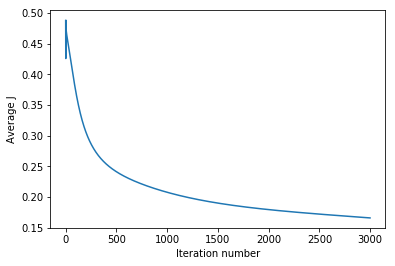

lambda used: 0.010278085328021954 n_neurons: 10
Training accuracy is 90.4494382022472%
Prediction accuracy is 82.35294117647058%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


C:\Users\razer\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in double_scalars
C:\Users\razer\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


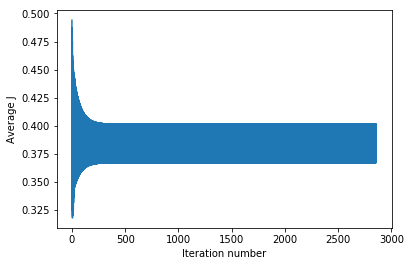

C:\Users\razer\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater


lambda used: 0.020000000000000004 n_neurons: 10
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


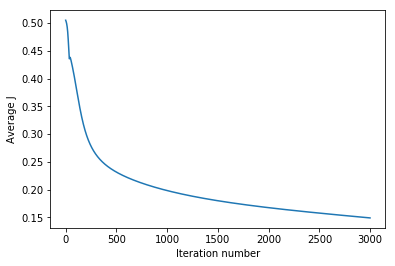

lambda used: 4.9999999999999996e-05 n_neurons: 18
Training accuracy is 92.13483146067416%
Prediction accuracy is 81.5126050420168%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


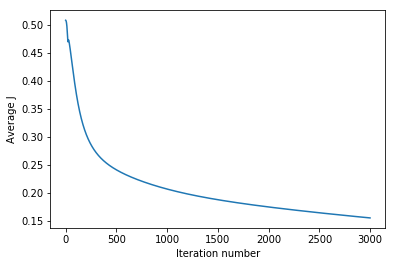

lambda used: 9.729438587881949e-05 n_neurons: 18
Training accuracy is 92.69662921348315%
Prediction accuracy is 80.67226890756302%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


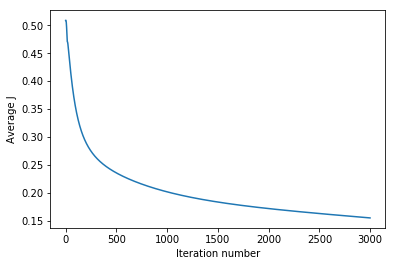

lambda used: 0.00018932395047073242 n_neurons: 18
Training accuracy is 91.01123595505618%
Prediction accuracy is 81.5126050420168%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


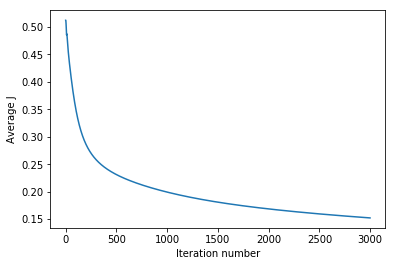

lambda used: 0.00036840314986403866 n_neurons: 18
Training accuracy is 91.01123595505618%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


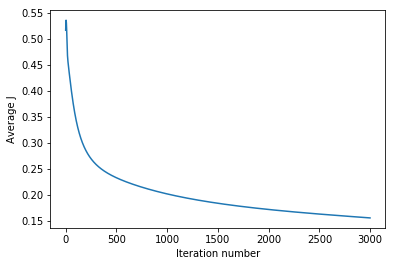

lambda used: 0.000716871164436887 n_neurons: 18
Training accuracy is 90.4494382022472%
Prediction accuracy is 78.99159663865547%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


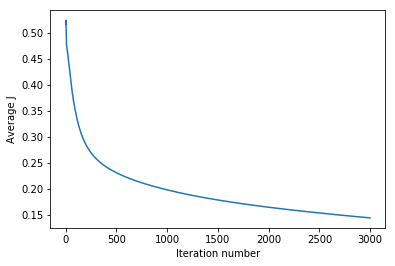

lambda used: 0.0013949507939624215 n_neurons: 18
Training accuracy is 94.3820224719101%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


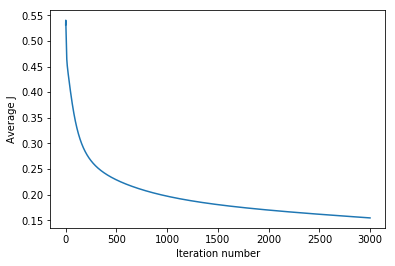

lambda used: 0.002714417616594907 n_neurons: 18
Training accuracy is 93.25842696629213%
Prediction accuracy is 80.67226890756302%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


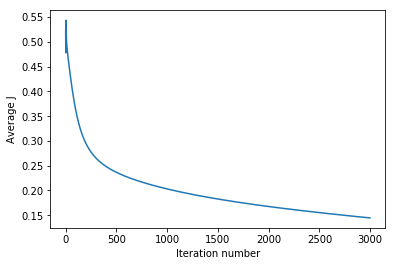

lambda used: 0.005281951900505007 n_neurons: 18
Training accuracy is 94.3820224719101%
Prediction accuracy is 78.99159663865547%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


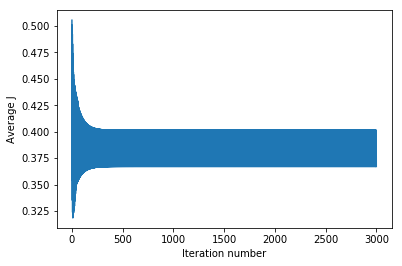

lambda used: 0.010278085328021954 n_neurons: 18
Training accuracy is 72.47191011235955%
Prediction accuracy is 80.67226890756302%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


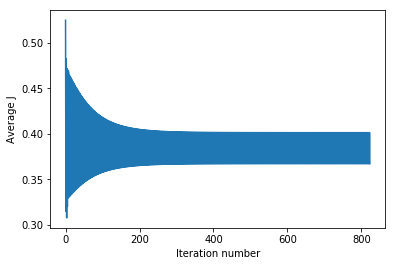

lambda used: 0.020000000000000004 n_neurons: 18
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


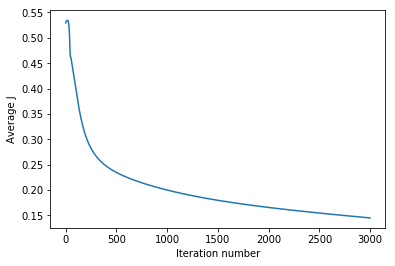

lambda used: 4.9999999999999996e-05 n_neurons: 26
Training accuracy is 93.82022471910112%
Prediction accuracy is 78.99159663865547%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


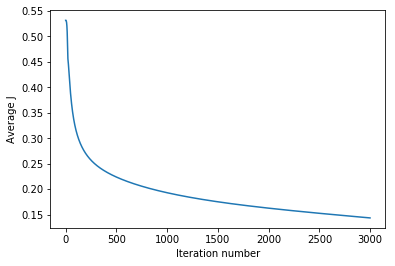

lambda used: 9.729438587881949e-05 n_neurons: 26
Training accuracy is 94.9438202247191%
Prediction accuracy is 77.31092436974791%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


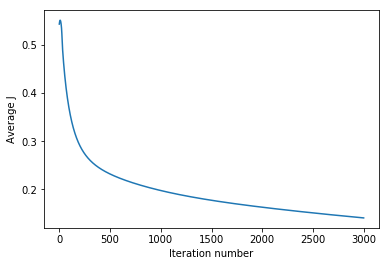

lambda used: 0.00018932395047073242 n_neurons: 26
Training accuracy is 94.3820224719101%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


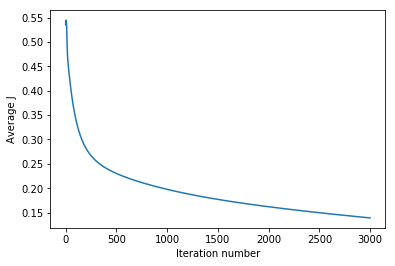

lambda used: 0.00036840314986403866 n_neurons: 26
Training accuracy is 94.3820224719101%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


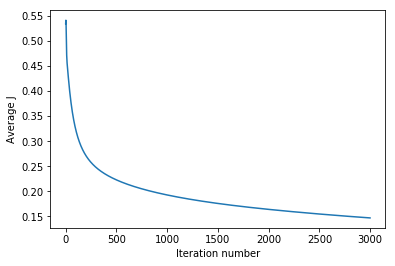

lambda used: 0.000716871164436887 n_neurons: 26
Training accuracy is 93.25842696629213%
Prediction accuracy is 77.31092436974791%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


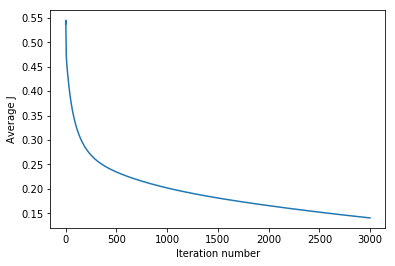

lambda used: 0.0013949507939624215 n_neurons: 26
Training accuracy is 94.3820224719101%
Prediction accuracy is 80.67226890756302%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


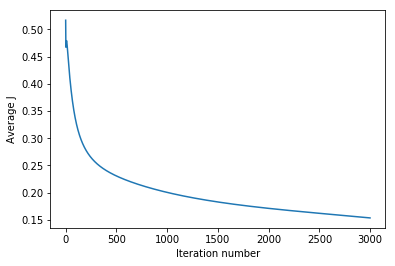

lambda used: 0.002714417616594907 n_neurons: 26
Training accuracy is 91.01123595505618%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


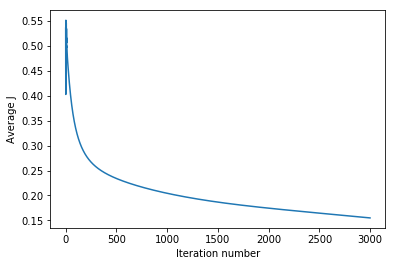

lambda used: 0.005281951900505007 n_neurons: 26
Training accuracy is 93.82022471910112%
Prediction accuracy is 78.15126050420169%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


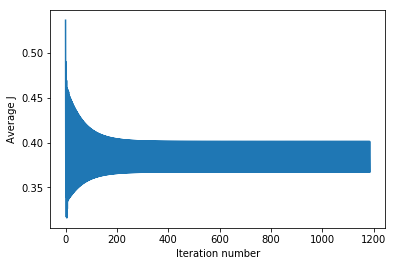

lambda used: 0.010278085328021954 n_neurons: 26
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


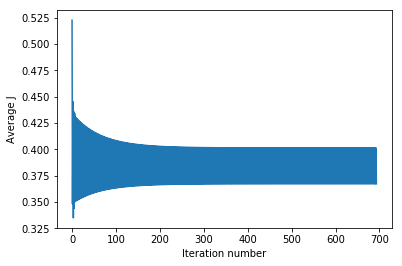

lambda used: 0.020000000000000004 n_neurons: 26
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


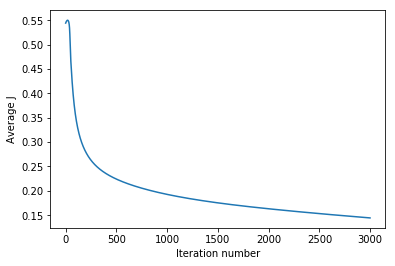

lambda used: 4.9999999999999996e-05 n_neurons: 34
Training accuracy is 93.82022471910112%
Prediction accuracy is 81.5126050420168%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


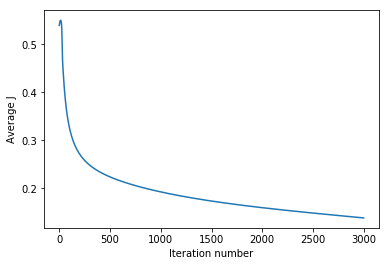

lambda used: 9.729438587881949e-05 n_neurons: 34
Training accuracy is 94.3820224719101%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


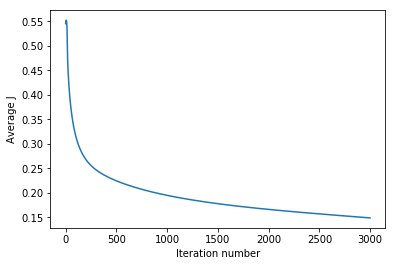

lambda used: 0.00018932395047073242 n_neurons: 34
Training accuracy is 94.3820224719101%
Prediction accuracy is 78.15126050420169%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


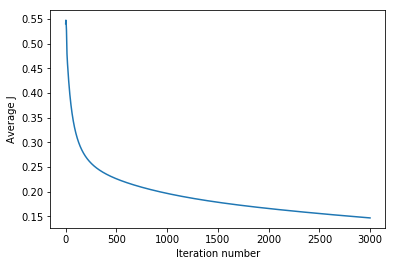

lambda used: 0.00036840314986403866 n_neurons: 34
Training accuracy is 94.3820224719101%
Prediction accuracy is 81.5126050420168%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


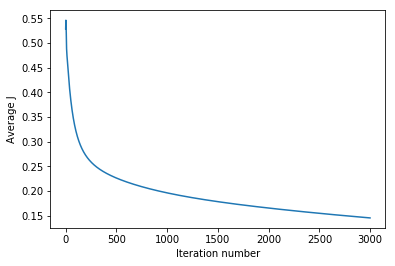

lambda used: 0.000716871164436887 n_neurons: 34
Training accuracy is 93.82022471910112%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


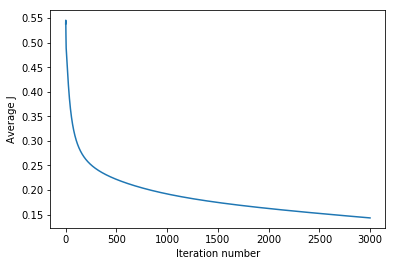

lambda used: 0.0013949507939624215 n_neurons: 34
Training accuracy is 92.69662921348315%
Prediction accuracy is 78.99159663865547%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


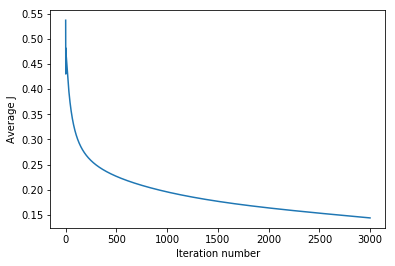

lambda used: 0.002714417616594907 n_neurons: 34
Training accuracy is 93.25842696629213%
Prediction accuracy is 78.99159663865547%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


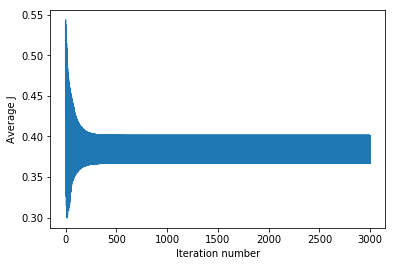

lambda used: 0.005281951900505007 n_neurons: 34
Training accuracy is 72.47191011235955%
Prediction accuracy is 80.67226890756302%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


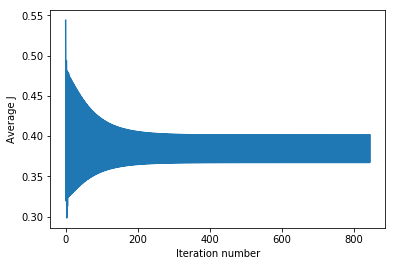

lambda used: 0.010278085328021954 n_neurons: 34
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


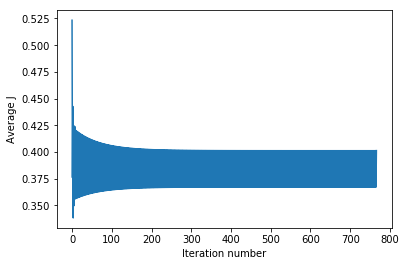

lambda used: 0.020000000000000004 n_neurons: 34
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


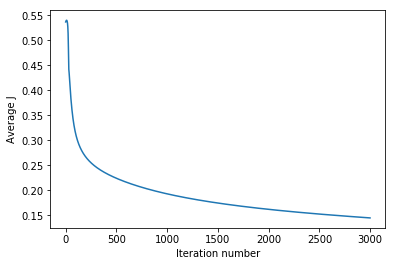

lambda used: 4.9999999999999996e-05 n_neurons: 42
Training accuracy is 92.69662921348315%
Prediction accuracy is 77.31092436974791%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


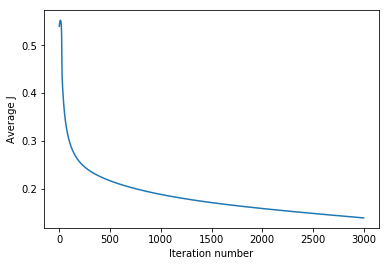

lambda used: 9.729438587881949e-05 n_neurons: 42
Training accuracy is 93.25842696629213%
Prediction accuracy is 80.67226890756302%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


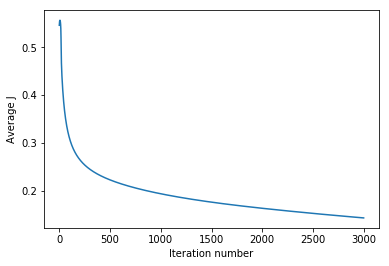

lambda used: 0.00018932395047073242 n_neurons: 42
Training accuracy is 94.9438202247191%
Prediction accuracy is 81.5126050420168%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


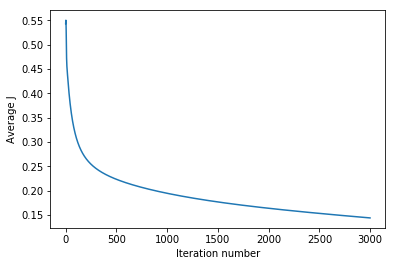

lambda used: 0.00036840314986403866 n_neurons: 42
Training accuracy is 93.25842696629213%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


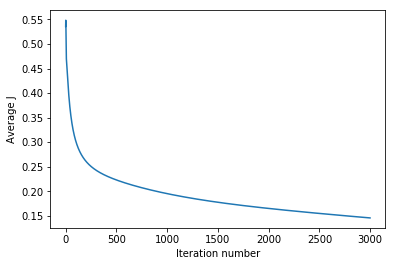

lambda used: 0.000716871164436887 n_neurons: 42
Training accuracy is 94.3820224719101%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


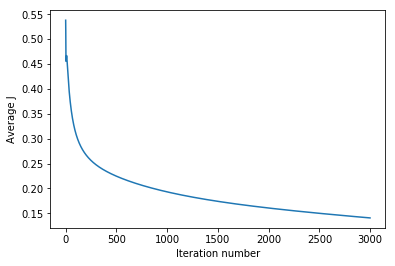

lambda used: 0.0013949507939624215 n_neurons: 42
Training accuracy is 92.69662921348315%
Prediction accuracy is 80.67226890756302%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


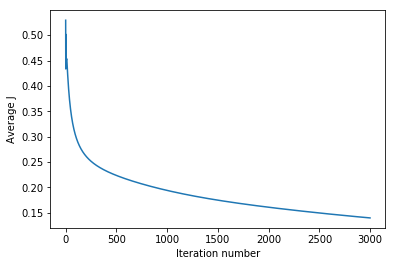

lambda used: 0.002714417616594907 n_neurons: 42
Training accuracy is 94.3820224719101%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


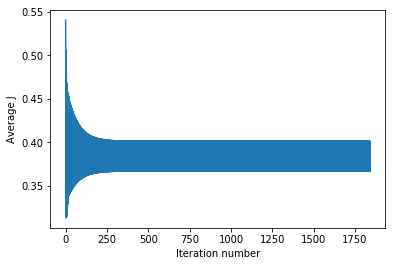

lambda used: 0.005281951900505007 n_neurons: 42
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


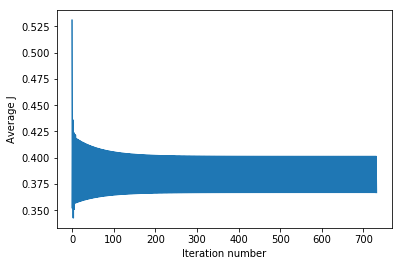

lambda used: 0.010278085328021954 n_neurons: 42
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


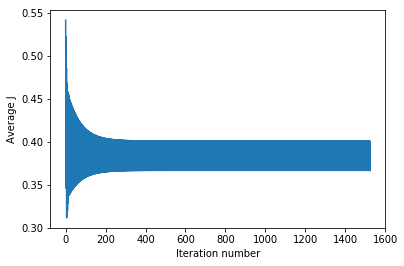

lambda used: 0.020000000000000004 n_neurons: 42
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


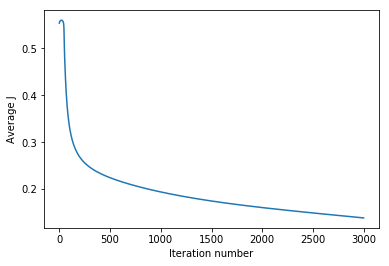

lambda used: 4.9999999999999996e-05 n_neurons: 50
Training accuracy is 93.82022471910112%
Prediction accuracy is 78.99159663865547%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


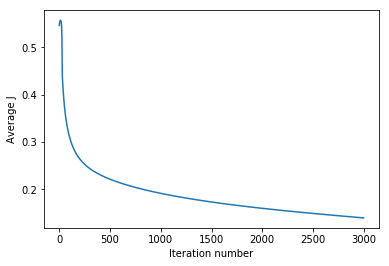

lambda used: 9.729438587881949e-05 n_neurons: 50
Training accuracy is 93.82022471910112%
Prediction accuracy is 78.99159663865547%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


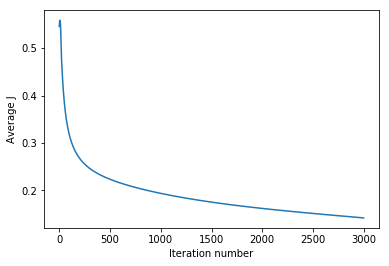

lambda used: 0.00018932395047073242 n_neurons: 50
Training accuracy is 93.25842696629213%
Prediction accuracy is 78.99159663865547%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


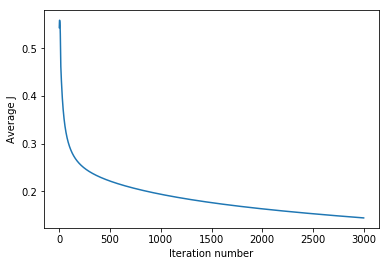

lambda used: 0.00036840314986403866 n_neurons: 50
Training accuracy is 94.3820224719101%
Prediction accuracy is 78.15126050420169%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


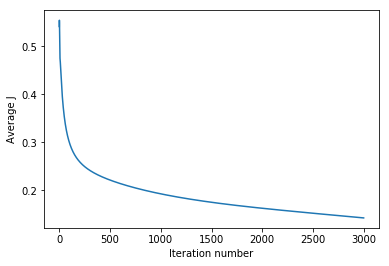

lambda used: 0.000716871164436887 n_neurons: 50
Training accuracy is 93.25842696629213%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


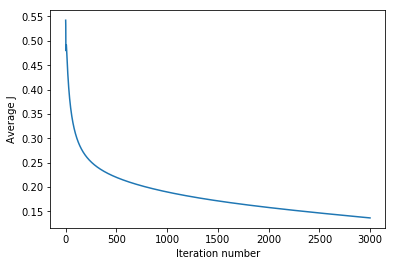

lambda used: 0.0013949507939624215 n_neurons: 50
Training accuracy is 93.82022471910112%
Prediction accuracy is 80.67226890756302%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


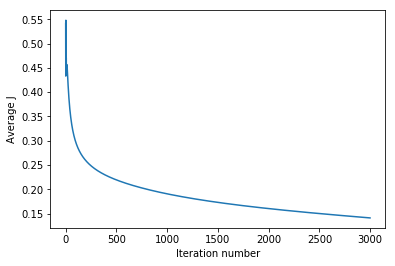

lambda used: 0.002714417616594907 n_neurons: 50
Training accuracy is 93.82022471910112%
Prediction accuracy is 78.99159663865547%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


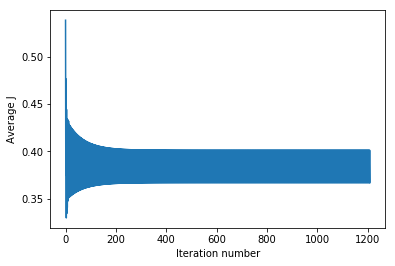

lambda used: 0.005281951900505007 n_neurons: 50
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


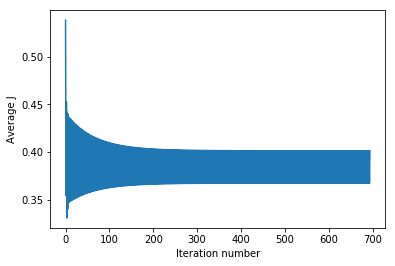

lambda used: 0.010278085328021954 n_neurons: 50
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


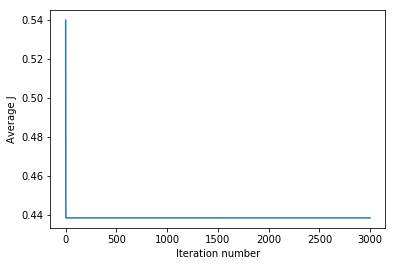

lambda used: 0.020000000000000004 n_neurons: 50
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%



In [517]:
info_small = [int(elem) for elem in np.linspace(3,50,7)]
lambs_small = np.geomspace(0.00005, 0.02, 10)

# print(info)
# print(lambs)
res_small = {}

for n_neuro in info_small:
    res_small[n_neuro] = []

    
for n_neuro in info_small: 
    acc_tr, acc_test = main(n_neuro, X_train, y_train, 3000, 0.5, lambs_small)

    res_small[n_neuro].append(acc_tr)
    res_small[n_neuro].append(acc_test)

In [520]:
print(info_small)
print(lambs_small)

[3, 10, 18, 26, 34, 42, 50]
[5.00000000e-05 9.72943859e-05 1.89323950e-04 3.68403150e-04
 7.16871164e-04 1.39495079e-03 2.71441762e-03 5.28195190e-03
 1.02780853e-02 2.00000000e-02]



Tr_acc, 3
0.9157303370786517
0.9213483146067416
0.9213483146067416
0.9101123595505618
0.9044943820224719
0.8932584269662921
0.8932584269662921
0.9101123595505618
0.898876404494382
0.9044943820224719

Test_acc, 3
0.7983193277310925
0.7983193277310925
0.773109243697479
0.7815126050420168
0.8151260504201681
0.8235294117647058
0.7983193277310925
0.7815126050420168
0.8235294117647058
0.7899159663865546



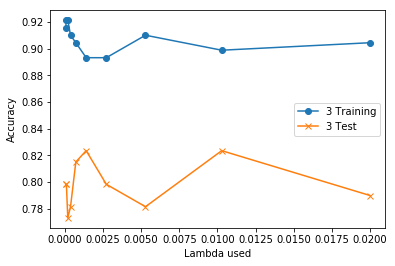


Tr_acc, 10
0.9157303370786517
0.898876404494382
0.9382022471910112
0.9325842696629213
0.9325842696629213
0.9101123595505618
0.898876404494382
0.9269662921348315
0.9044943820224719
0.5617977528089888

Test_acc, 10
0.7983193277310925
0.8151260504201681
0.773109243697479
0.8235294117647058
0.8151260504201681
0.8151260504201681
0.8067226890756303
0.773109243697479
0.8235294117647058
0.5042016806722689



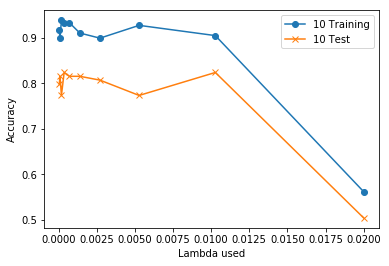


Tr_acc, 18
0.9213483146067416
0.9269662921348315
0.9101123595505618
0.9101123595505618
0.9044943820224719
0.9438202247191011
0.9325842696629213
0.9438202247191011
0.7247191011235955
0.5617977528089888

Test_acc, 18
0.8151260504201681
0.8067226890756303
0.8151260504201681
0.7983193277310925
0.7899159663865546
0.7983193277310925
0.8067226890756303
0.7899159663865546
0.8067226890756303
0.5042016806722689



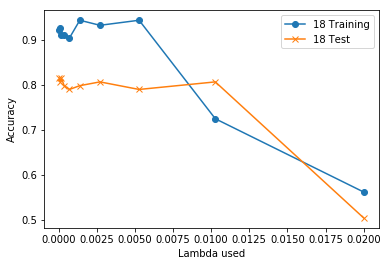


Tr_acc, 26
0.9382022471910112
0.949438202247191
0.9438202247191011
0.9438202247191011
0.9325842696629213
0.9438202247191011
0.9101123595505618
0.9382022471910112
0.5617977528089888
0.5617977528089888

Test_acc, 26
0.7899159663865546
0.773109243697479
0.7983193277310925
0.7983193277310925
0.773109243697479
0.8067226890756303
0.7983193277310925
0.7815126050420168
0.5042016806722689
0.5042016806722689



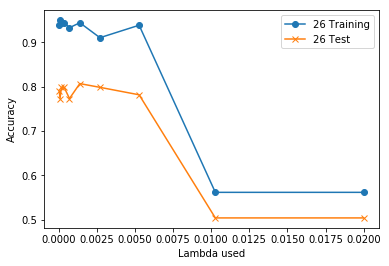


Tr_acc, 34
0.9382022471910112
0.9438202247191011
0.9438202247191011
0.9438202247191011
0.9382022471910112
0.9269662921348315
0.9325842696629213
0.7247191011235955
0.5617977528089888
0.5617977528089888

Test_acc, 34
0.8151260504201681
0.7983193277310925
0.7815126050420168
0.8151260504201681
0.7983193277310925
0.7899159663865546
0.7899159663865546
0.8067226890756303
0.5042016806722689
0.5042016806722689



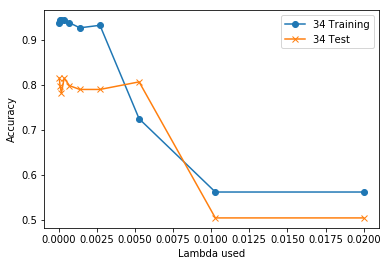


Tr_acc, 42
0.9269662921348315
0.9325842696629213
0.949438202247191
0.9325842696629213
0.9438202247191011
0.9269662921348315
0.9438202247191011
0.5617977528089888
0.5617977528089888
0.5617977528089888

Test_acc, 42
0.773109243697479
0.8067226890756303
0.8151260504201681
0.7983193277310925
0.7983193277310925
0.8067226890756303
0.7983193277310925
0.5042016806722689
0.5042016806722689
0.5042016806722689



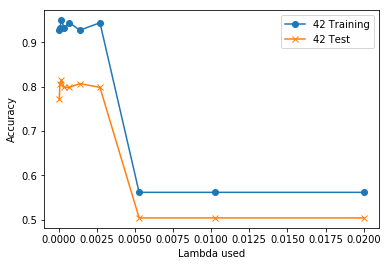


Tr_acc, 50
0.9382022471910112
0.9382022471910112
0.9325842696629213
0.9438202247191011
0.9325842696629213
0.9382022471910112
0.9382022471910112
0.5617977528089888
0.5617977528089888
0.5617977528089888

Test_acc, 50
0.7899159663865546
0.7899159663865546
0.7899159663865546
0.7815126050420168
0.7983193277310925
0.8067226890756303
0.7899159663865546
0.5042016806722689
0.5042016806722689
0.5042016806722689



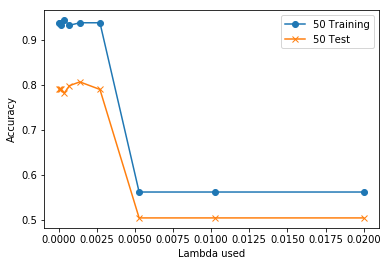

In [522]:
x = lambs_small

for n_neu in res_small:
    tr_lst = []
    test_lst = []
    
    print()
    print("Tr_acc,",n_neu)
    for tr_accs in res_small[n_neu][0]:
        tr_lst.append(tr_accs[1])
        print(tr_accs[1])
        
    print()
    
    print("Test_acc,",n_neu)
    for test_accs in res_small[n_neu][1]:
        test_lst.append(test_accs[1])
        print(test_accs[1])
    print()
    
    plt.plot(x,tr_lst,marker='o', label=str(n_neu)+" Training")
    plt.plot(x,test_lst,marker='x', label=str(n_neu)+" Test")
    
    plt.xlabel('Lambda used')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


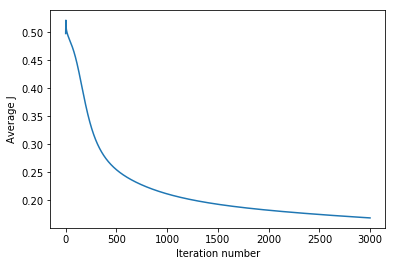

lambda used: 0.01 n_neurons: 4
Training accuracy is 92.13483146067416%
Prediction accuracy is 78.99159663865547%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


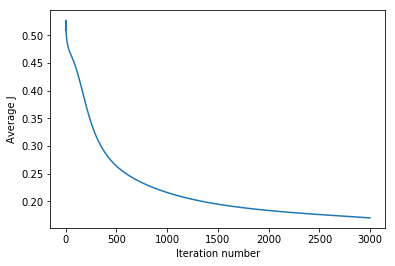

lambda used: 0.013510667516017707 n_neurons: 4
Training accuracy is 92.13483146067416%
Prediction accuracy is 78.15126050420169%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


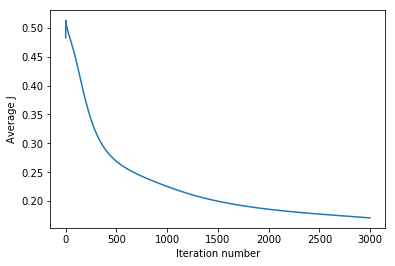

lambda used: 0.018253813672837616 n_neurons: 4
Training accuracy is 91.01123595505618%
Prediction accuracy is 78.15126050420169%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


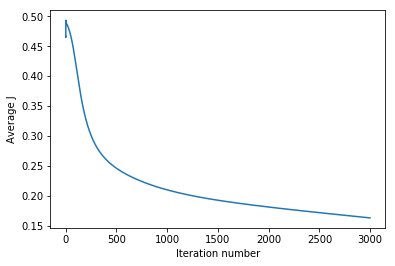

lambda used: 0.0246621207433047 n_neurons: 4
Training accuracy is 92.69662921348315%
Prediction accuracy is 78.99159663865547%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


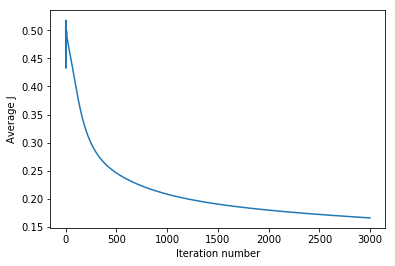

lambda used: 0.033320171360267346 n_neurons: 4
Training accuracy is 92.13483146067416%
Prediction accuracy is 77.31092436974791%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


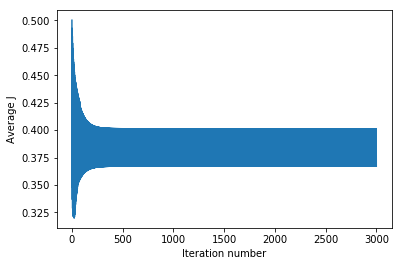

lambda used: 0.04501777568253076 n_neurons: 4
Training accuracy is 72.47191011235955%
Prediction accuracy is 80.67226890756302%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000


C:\Users\razer\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in double_scalars
C:\Users\razer\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


Iteration 2000 of 3000


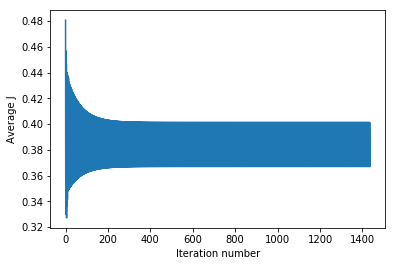

C:\Users\razer\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater


lambda used: 0.06082201995573401 n_neurons: 4
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


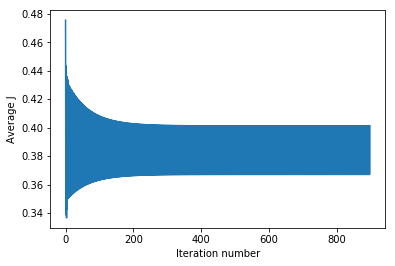

lambda used: 0.08217460892745167 n_neurons: 4
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


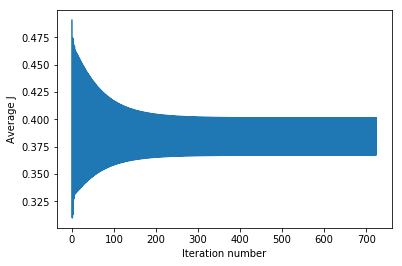

lambda used: 0.11102338194775797 n_neurons: 4
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


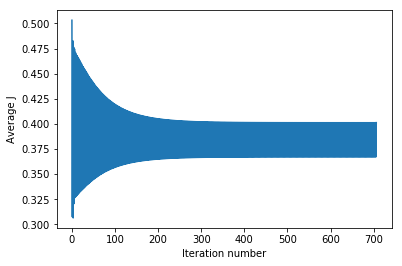

lambda used: 0.15 n_neurons: 4
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


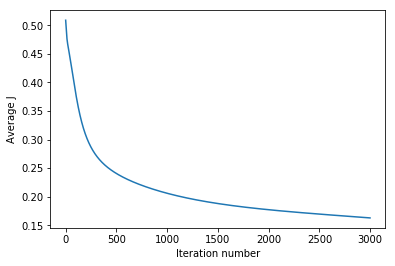

lambda used: 0.01 n_neurons: 8
Training accuracy is 91.01123595505618%
Prediction accuracy is 82.35294117647058%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


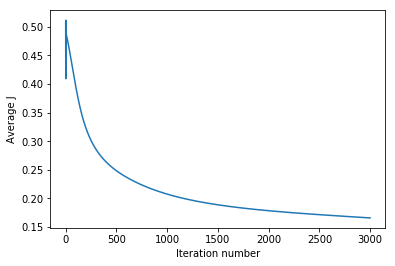

lambda used: 0.013510667516017707 n_neurons: 8
Training accuracy is 89.8876404494382%
Prediction accuracy is 80.67226890756302%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


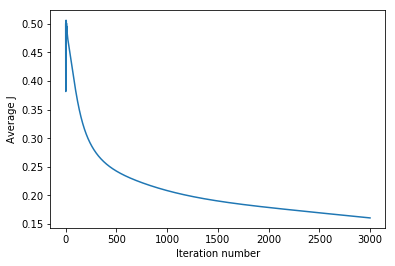

lambda used: 0.018253813672837616 n_neurons: 8
Training accuracy is 92.69662921348315%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


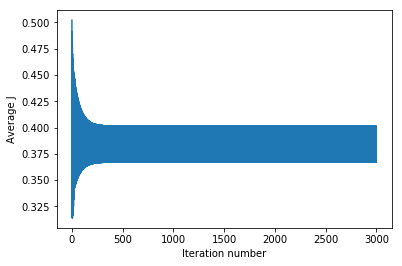

lambda used: 0.0246621207433047 n_neurons: 8
Training accuracy is 72.47191011235955%
Prediction accuracy is 80.67226890756302%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


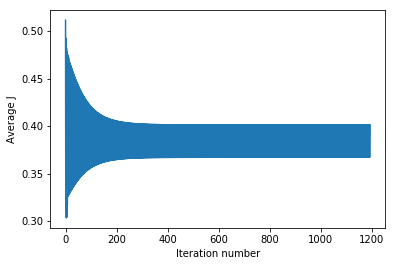

lambda used: 0.033320171360267346 n_neurons: 8
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


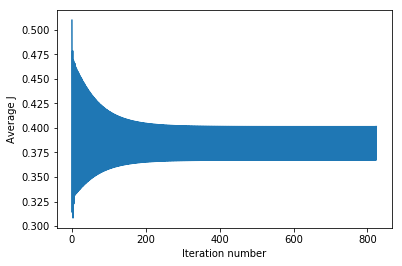

lambda used: 0.04501777568253076 n_neurons: 8
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


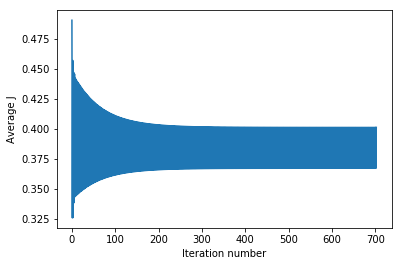

lambda used: 0.06082201995573401 n_neurons: 8
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


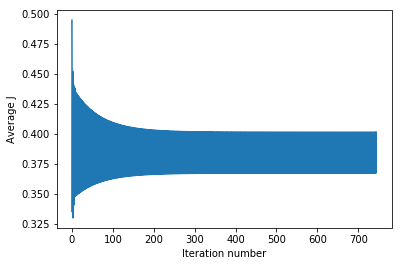

lambda used: 0.08217460892745167 n_neurons: 8
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


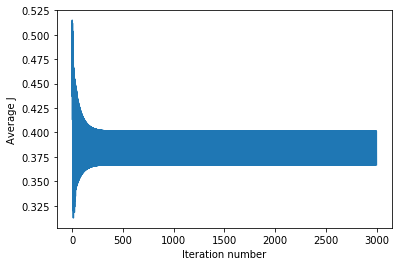

lambda used: 0.11102338194775797 n_neurons: 8
Training accuracy is 72.47191011235955%
Prediction accuracy is 80.67226890756302%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


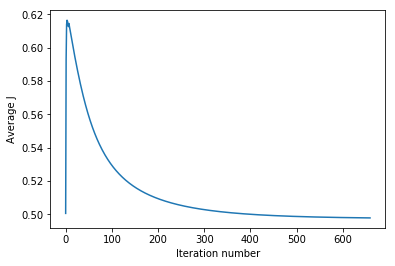

lambda used: 0.15 n_neurons: 8
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


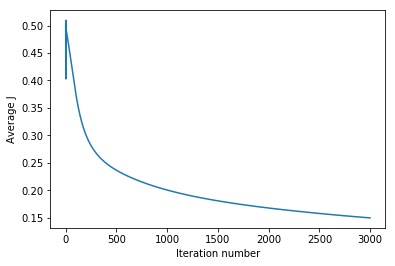

lambda used: 0.01 n_neurons: 12
Training accuracy is 92.69662921348315%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


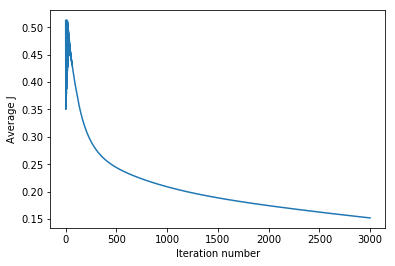

lambda used: 0.013510667516017707 n_neurons: 12
Training accuracy is 93.82022471910112%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


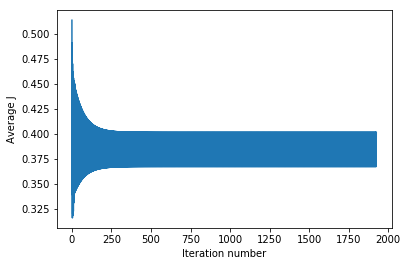

lambda used: 0.018253813672837616 n_neurons: 12
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


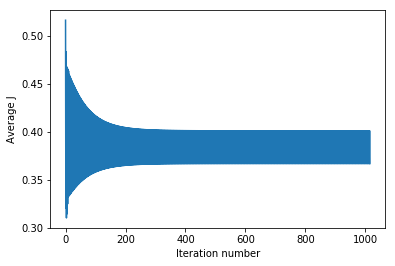

lambda used: 0.0246621207433047 n_neurons: 12
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


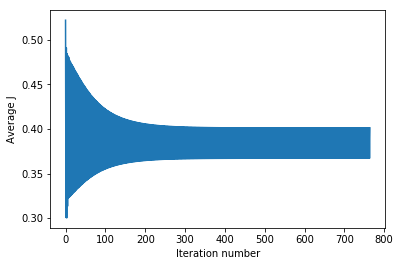

lambda used: 0.033320171360267346 n_neurons: 12
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


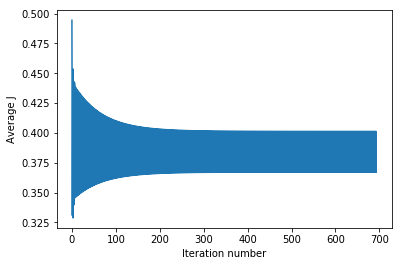

lambda used: 0.04501777568253076 n_neurons: 12
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


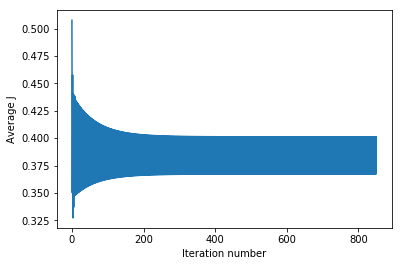

lambda used: 0.06082201995573401 n_neurons: 12
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


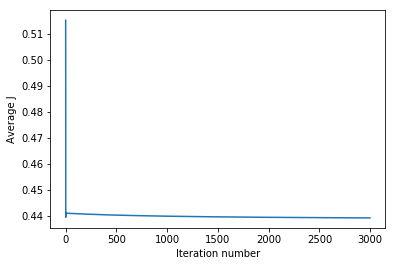

lambda used: 0.08217460892745167 n_neurons: 12
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


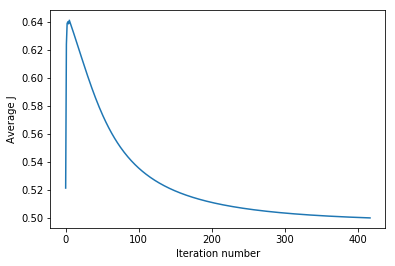

lambda used: 0.11102338194775797 n_neurons: 12
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


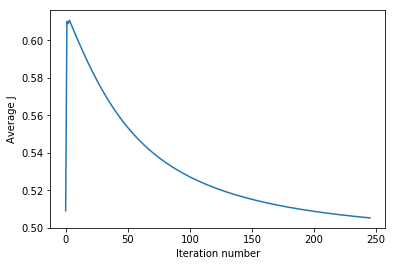

lambda used: 0.15 n_neurons: 12
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


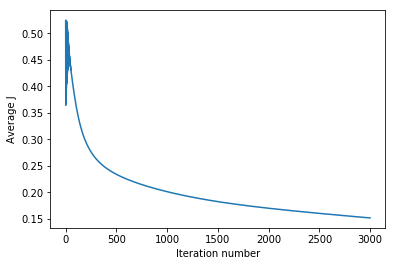

lambda used: 0.01 n_neurons: 16
Training accuracy is 93.25842696629213%
Prediction accuracy is 79.83193277310924%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


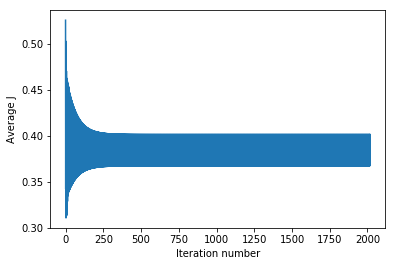

lambda used: 0.013510667516017707 n_neurons: 16
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


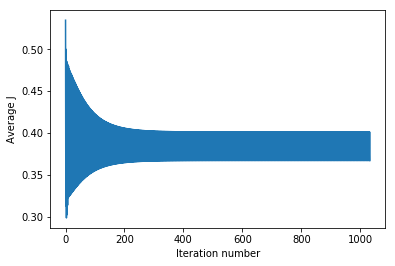

lambda used: 0.018253813672837616 n_neurons: 16
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


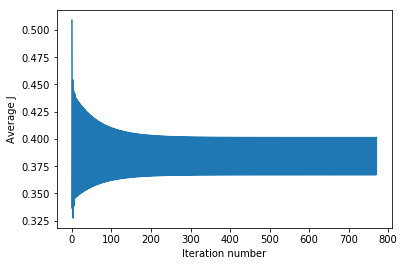

lambda used: 0.0246621207433047 n_neurons: 16
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


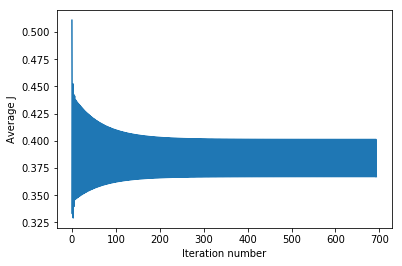

lambda used: 0.033320171360267346 n_neurons: 16
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


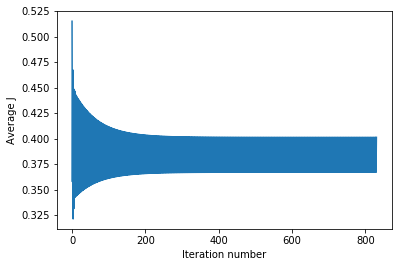

lambda used: 0.04501777568253076 n_neurons: 16
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


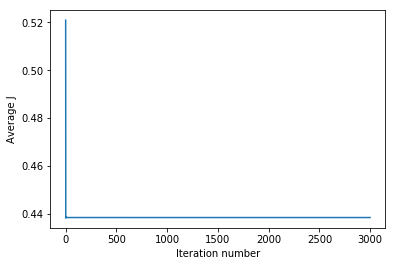

lambda used: 0.06082201995573401 n_neurons: 16
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


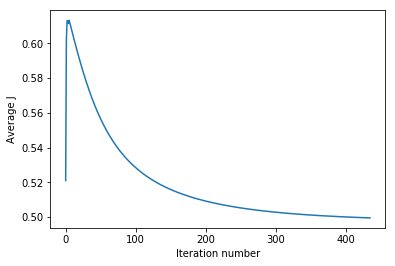

lambda used: 0.08217460892745167 n_neurons: 16
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


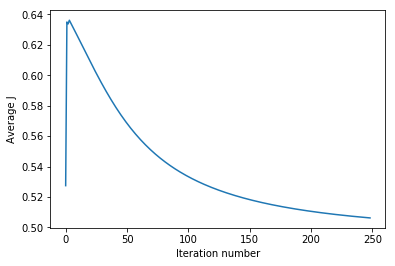

lambda used: 0.11102338194775797 n_neurons: 16
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


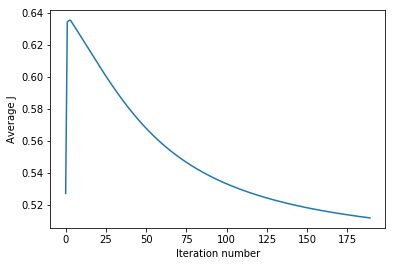

lambda used: 0.15 n_neurons: 16
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


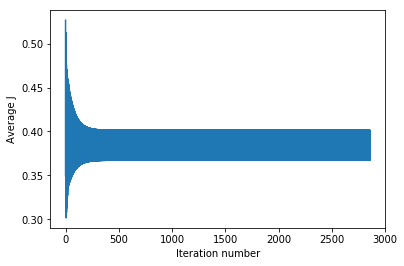

lambda used: 0.01 n_neurons: 20
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


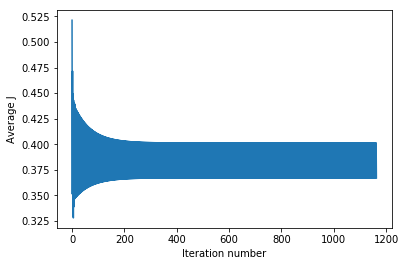

lambda used: 0.013510667516017707 n_neurons: 20
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


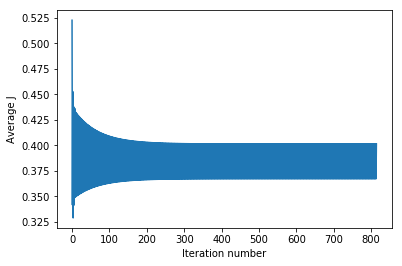

lambda used: 0.018253813672837616 n_neurons: 20
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


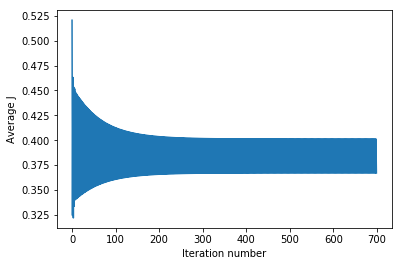

lambda used: 0.0246621207433047 n_neurons: 20
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


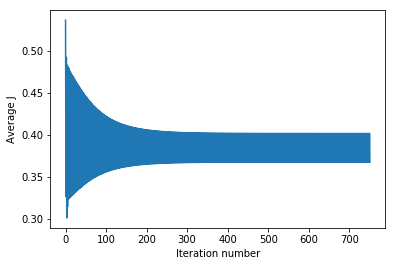

lambda used: 0.033320171360267346 n_neurons: 20
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


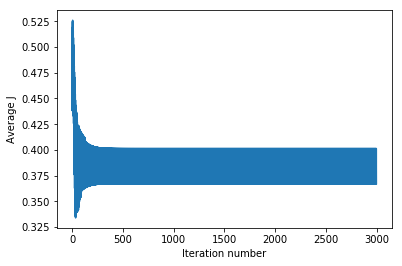

lambda used: 0.04501777568253076 n_neurons: 20
Training accuracy is 72.47191011235955%
Prediction accuracy is 80.67226890756302%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


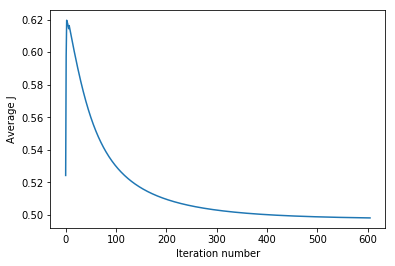

lambda used: 0.06082201995573401 n_neurons: 20
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


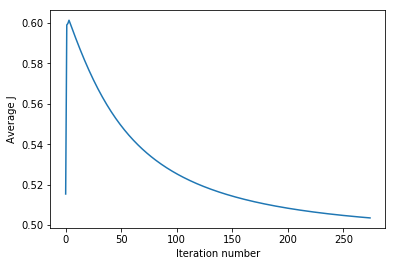

lambda used: 0.08217460892745167 n_neurons: 20
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


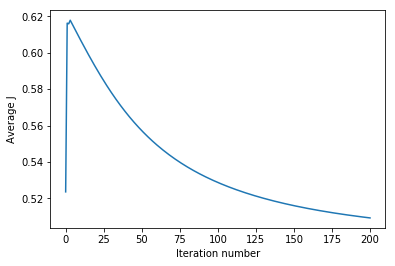

lambda used: 0.11102338194775797 n_neurons: 20
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


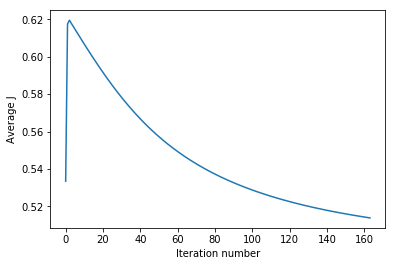

lambda used: 0.15 n_neurons: 20
Training accuracy is 56.17977528089888%
Prediction accuracy is 50.42016806722689%



In [523]:
info_2 = [int(elem) for elem in np.linspace(4,20,5)]
lambs_2 = np.geomspace(0.01, 0.15, 10)

# print(info)
# print(lambs)
res_2 = {}

for n_neuro in info_2:
    res_2[n_neuro] = []

    
for n_neuro in info_2: 
    acc_tr, acc_test = main(n_neuro, X_train, y_train, 3000, 0.5, lambs_2)

    res_2[n_neuro].append(acc_tr)
    res_2[n_neuro].append(acc_test)